# Graphing Sentinel 2 metrics against Tumbarumba ground data

In [1]:
import ipyleaflet
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pystac
import pystac_client
import planetary_computer
import requests
import rich.table
import xarray as xr 
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import pandas as pd
import datetime as dt
from IPython.display import Image

/tmp/ipykernel_399/3380644382.py:11: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
/tmp/ipykernel_399/3380644382.py:12: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


## Load Data

### Load Ground Sensed Metrics

### Soil Moisture and Precipitation

Precipitation data

In [2]:
ds_2019 = pd.read_csv('2019_Tumba_Sws_Precip.csv', index_col=0)
ds_2021 = pd.read_csv('2021_Tumba_SoilM_Precip.csv', index_col=0)

# Adding formatted datetime column to 2019 data
ds_2019['date'] = pd.date_range(start='1/1/2019', periods=len(ds_2019), freq='H')
# Adding formatted datetime column to 2021 data
ds_2021['date'] = pd.date_range(start='09/11/2021', periods=len(ds_2021), freq='H')

Soil Moisture

In [3]:
# Adding 2001 - 2018 Sws
ds_01_18 = pd.read_csv('Tumbarumba_2001_2018_Sws_Clean.csv', index_col=0)
# Adding formatted Datetime column to data
ds_01_18['date'] = pd.date_range(start='22/02/2001', periods=len(ds_01_18), freq='H')

/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3378: UserWarning: Parsing '22/02/2001' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


Leaf Area Index (LAI)

In [4]:
PAI_2019_df = pd.read_csv('PAI_final_results_copy.csv', index_col=0)

### Load S2 Sandbox Metrics

In [5]:
EVI_df = pd.read_csv('EVI_smoothed_mean.csv')
Green_df = pd.read_csv('Green_smoothed_mean.csv')
NDVI_df = pd.read_csv('NDVI_smoothed_mean.csv')
NIR_df = pd.read_csv('NIR_smoothed_mean.csv')
SWIR_df = pd.read_csv('SWIR_smoothed_mean.csv')

### Load S1 Smoothed Results

In [6]:
VV_smooth_df  = pd.read_csv('VV_smooth_df.csv')
VH_smooth_df  = pd.read_csv('VH_smooth_df.csv')
VH_smooth_std = pd.read_csv('VH_smooth_std.csv')

In [10]:
VV_VH_df = VV_smooth_df['vv_dB']/VH_smooth_df['vh_dB']
VV_VH_df = VV_VH_df.to_xarray()
VV_VH_df = VV_VH_df.to_dataframe(name = 'VV_VH')
VV_VH_df['time'] = VH_smooth_df['time']

In [11]:
VV_VH_df['mov_avg'] = VV_VH_df['VV_VH'].rolling(2).sum()

In [9]:
VH_VV_df = VH_smooth_df['vh_dB']/VV_smooth_df['vv_dB']
VH_VV_df = VH_VV_df.to_xarray()
VH_VV_df = VH_VV_df.to_dataframe(name = 'VH_VV')
VH_VV_df['time'] = VH_smooth_df['time']

In [10]:
#VV_VH_df.to_csv('VV_VH_df.csv', index='time')

Convert time column to datetime data type for timeseries analysis

In [9]:
EVI_df['time'] = pd.to_datetime(EVI_df['time'],dayfirst=True)
Green_df['time'] = pd.to_datetime(Green_df['time'],dayfirst=True)
NDVI_df['time'] = pd.to_datetime(NDVI_df['time'],dayfirst=True)
NIR_df['time'] = pd.to_datetime(NIR_df['time'],dayfirst=True)
SWIR_df['time'] = pd.to_datetime(SWIR_df['time'],dayfirst=True)
VV_smooth_df['time'] = pd.to_datetime(VV_smooth_df['time'],dayfirst=True)
VH_smooth_df['time'] = pd.to_datetime(VH_smooth_df['time'],dayfirst=True)
VH_smooth_std['time'] = pd.to_datetime(VH_smooth_std['time'],dayfirst=True)
PAI_2019_df['time'] = pd.to_datetime(PAI_2019_df['time'],dayfirst=True)

# SENTINEL 2 COMPARISON SOIL MOISTURE

### Ground Sensed Sws 2001 - 2019
Plotting the time series as a test

Plot: 


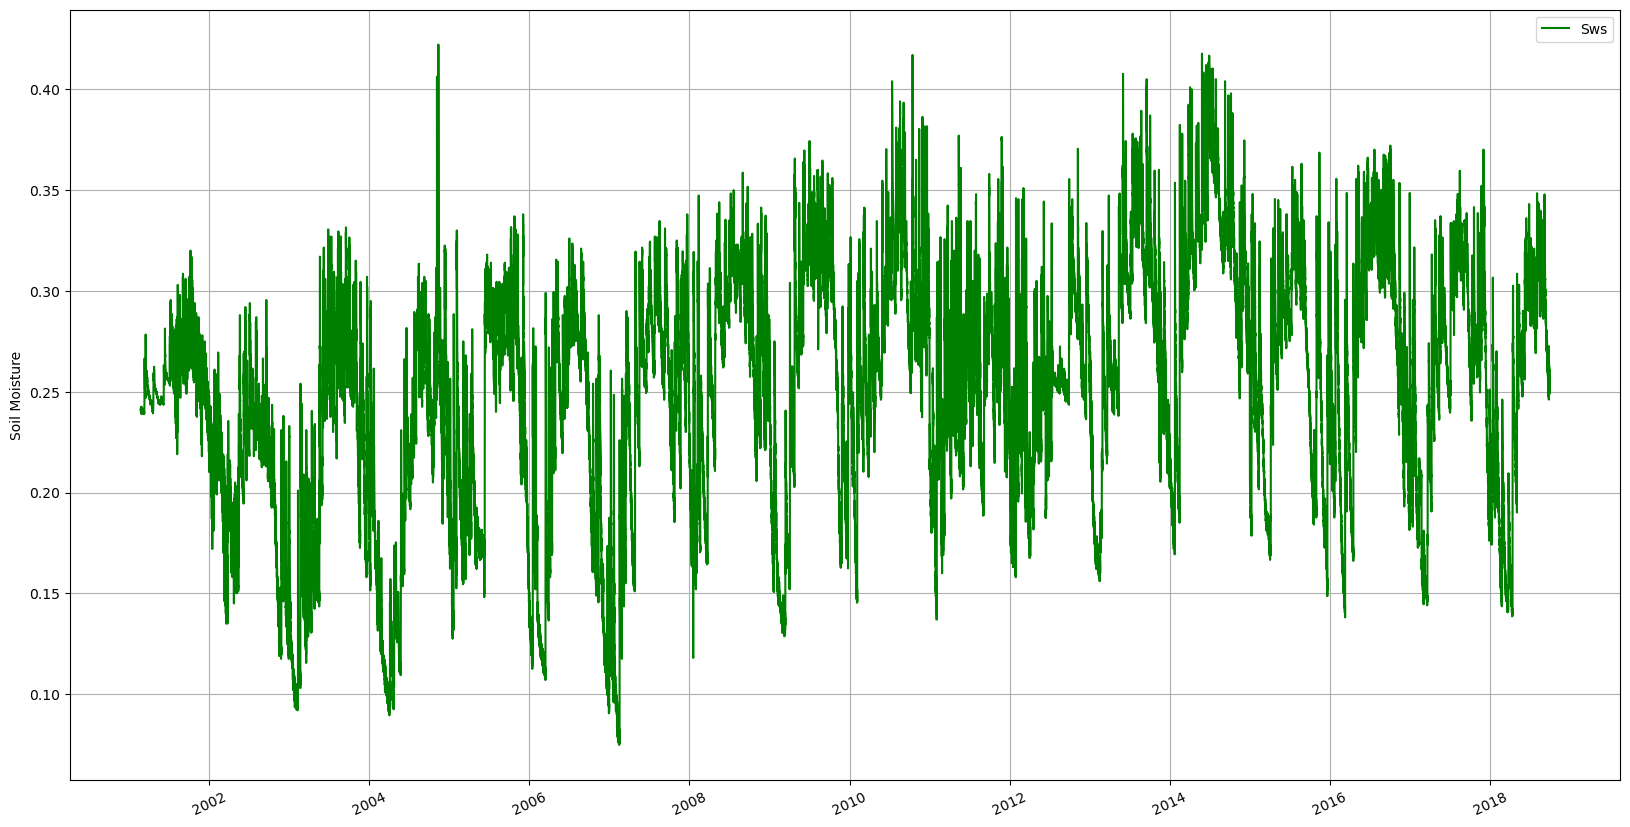

In [8]:
x2 = ds_01_18['date'].iloc[16:]
y2 = ds_01_18['Sws'].iloc[16:]

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")

plt.grid()

#plt.subplot(212)
#plt.twinx()
line1, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1])
#plt.grid()

plt.show()

### EVI with Ground Sensed Soil Moisture 2016-2018

Plot: 


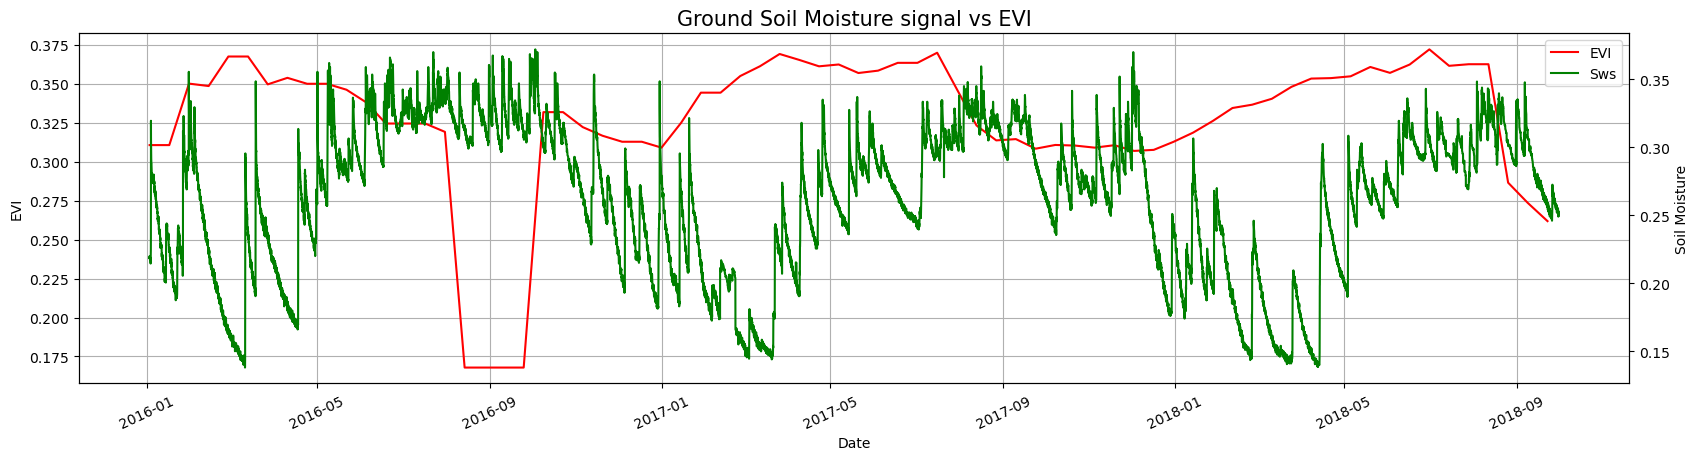

In [9]:
xarr = EVI_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2016-01','2018-09-30'))

x = selection['index']
x2 = ds_01_18['date'].iloc[130272:]
y1 = selection['EVI']
y2 = ds_01_18['Sws'].iloc[130272:]

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "EVI")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('EVI')
plt.title('Ground Soil Moisture signal vs EVI', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
#plt.grid()

plt.show()

### EVI with Ground Sensed Soil Moisture 2019 - 2020

Plot: 


/tmp/ipykernel_416/2243013616.py:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')


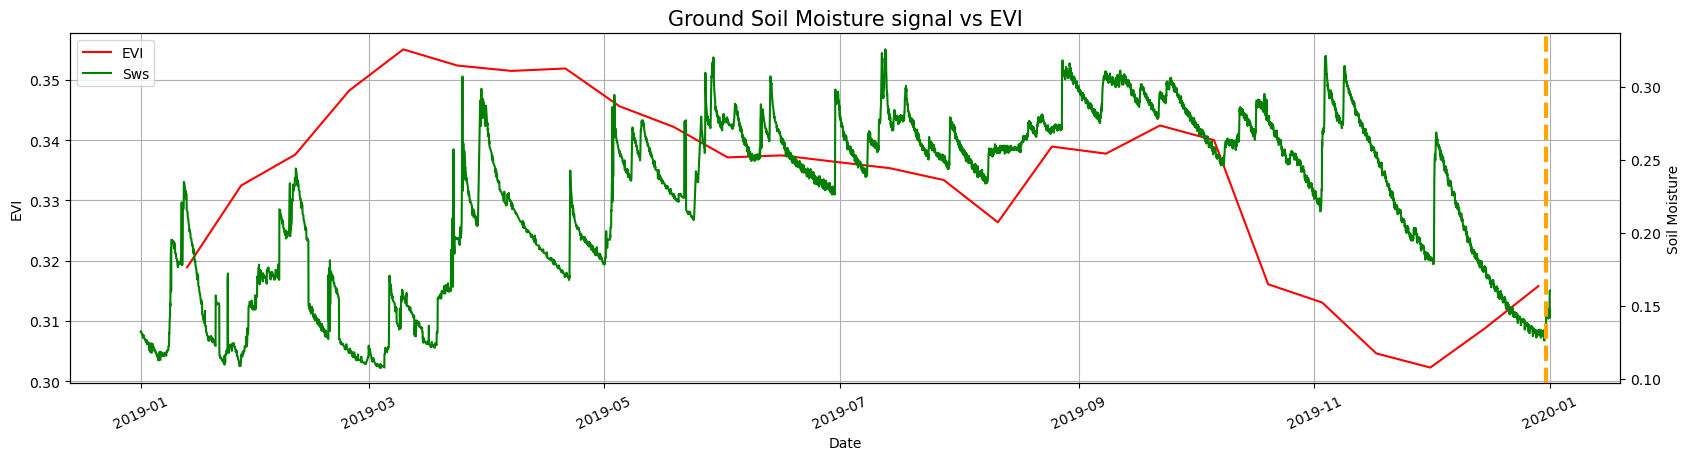

In [10]:
xarr = EVI_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2019-01','2020-01-01'))

x = selection['index']
x2 = ds_2019['date']
y1 = selection['EVI']
y2 = ds_2019['Sws']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "EVI")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('EVI')
plt.title('Ground Soil Moisture signal vs EVI', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
#plt.grid()

plt.show()

### Tascelled Cap Greeness with Ground Sensed Soil Moisture 2016 - 2018

Plot: 


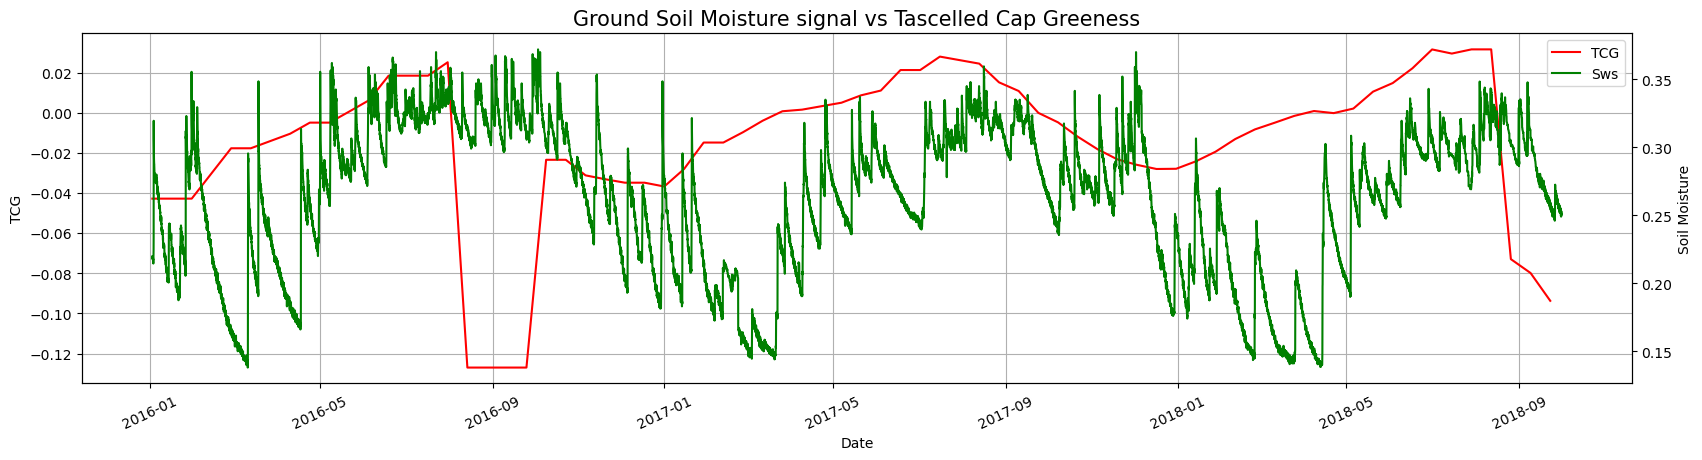

In [11]:
xarr = Green_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2016-01','2018-09-30'))

x = selection['index']
x2 = ds_01_18['date'].iloc[130272:]
y1 = selection['Green']
y2 = y2 = ds_01_18['Sws'].iloc[130272:]

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "TCG")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('TCG')
plt.title('Ground Soil Moisture signal vs Tascelled Cap Greeness', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
#plt.grid()

plt.show()

### Tascelled Cap Greeness with Ground Sensed Soil Moisture 2019 - 2020

Plot: 


/tmp/ipykernel_416/2609770277.py:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')


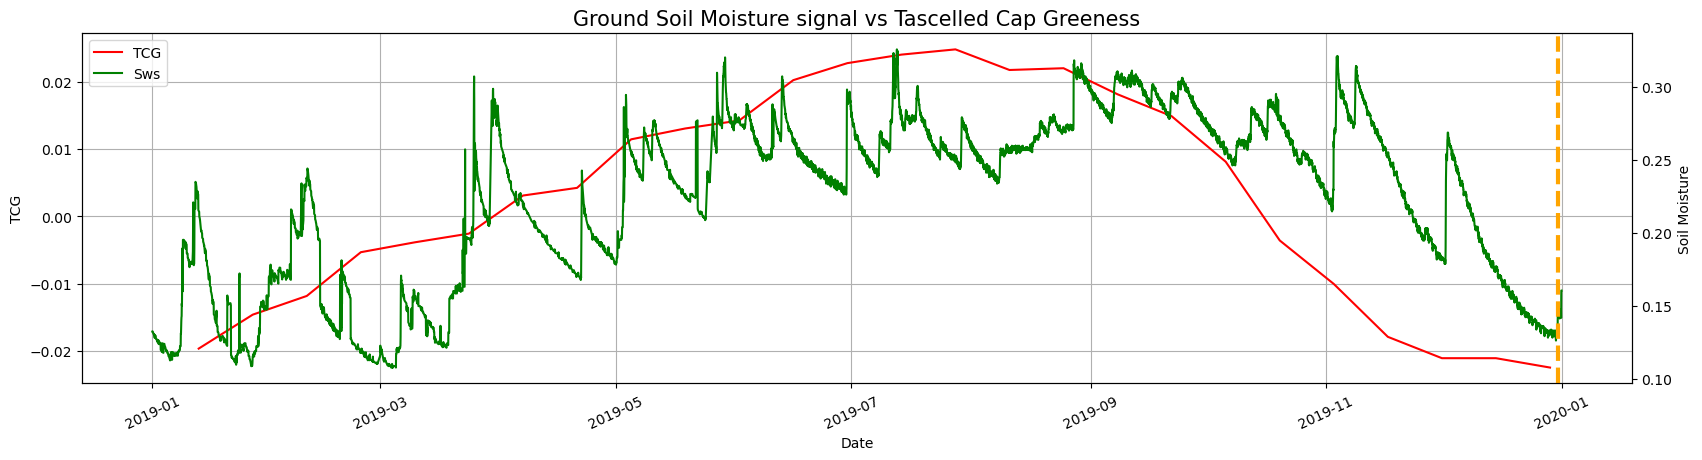

In [12]:
xarr = Green_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2019-01','2020-01-01'))

x = selection['index']
x2 = ds_2019['date']
y1 = selection['Green']
y2 = ds_2019['Sws']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "TCG")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('TCG')
plt.title('Ground Soil Moisture signal vs Tascelled Cap Greeness', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
#plt.grid()

plt.show()

### NDVI with Ground Sensed Soil Moisture 2016 - 2018

Plot: 


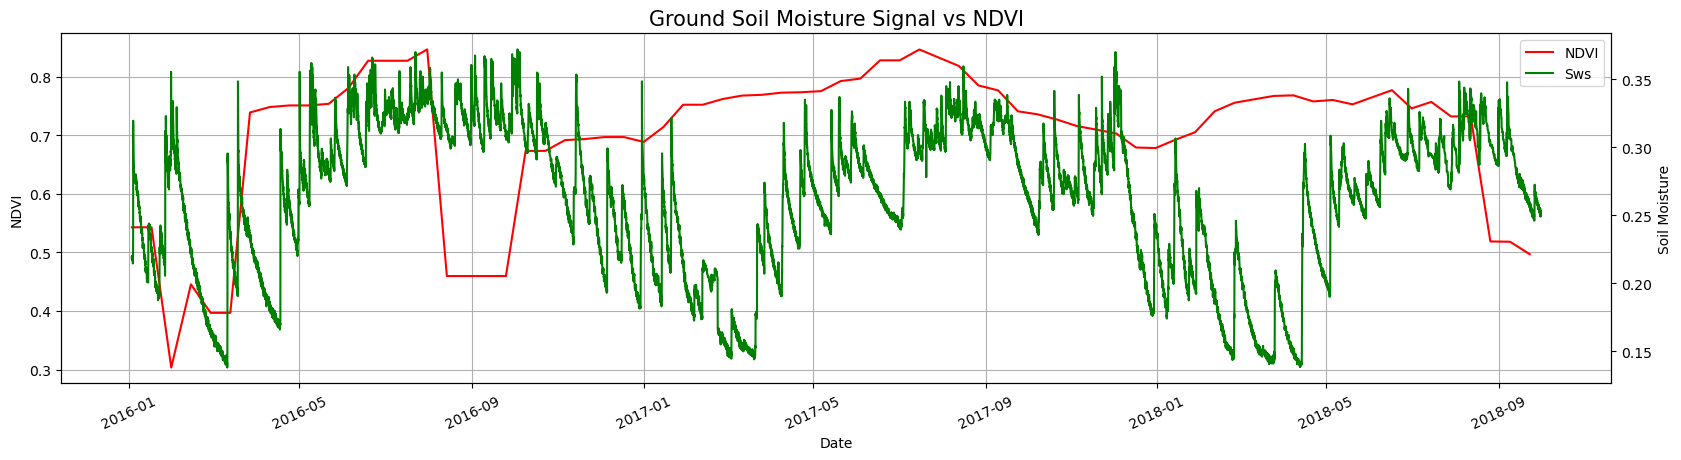

In [13]:
xarr = NDVI_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2016-01','2018-09-30'))

x = selection['index']
x2 = ds_01_18['date'].iloc[130272:]
y1 = selection['NDVI']
y2 = ds_01_18['Sws'].iloc[130272:]

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "NDVI")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('Ground Soil Moisture Signal vs NDVI', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
#plt.grid()

plt.show()

### NDVI with Ground Sensed Soil Moisture 2019 - 2020

Plot: 


/tmp/ipykernel_416/3353149440.py:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')


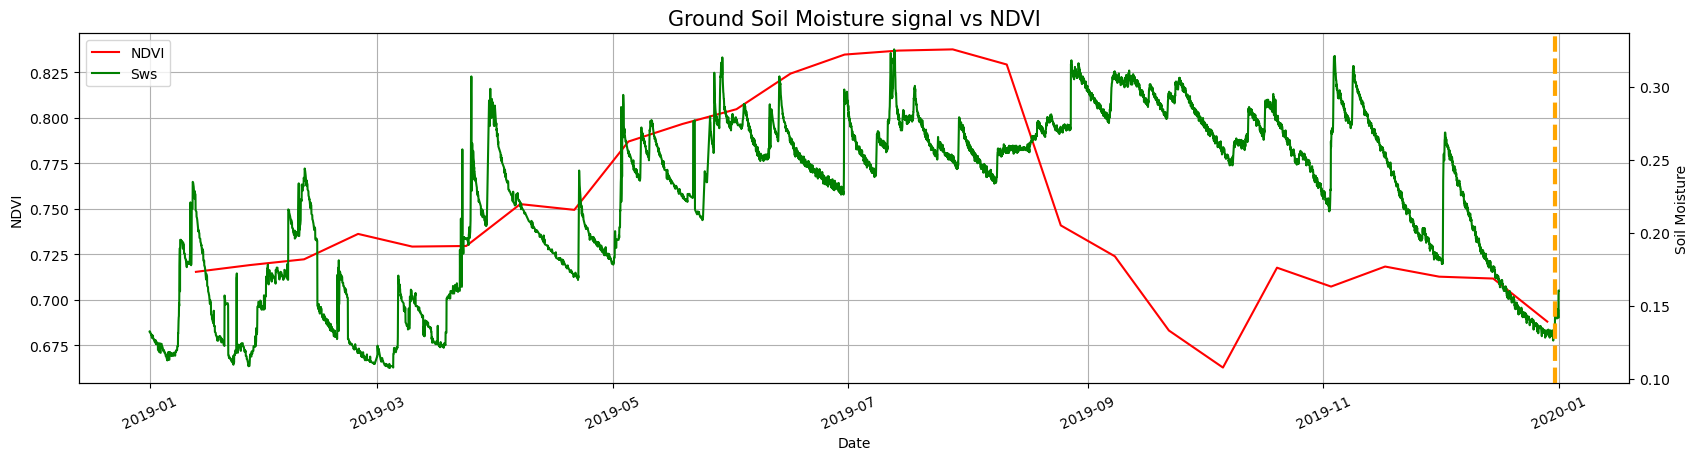

In [14]:
xarr = NDVI_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2019-01','2020-01-01'))

x = selection['index']
x2 = ds_2019['date']
y1 = selection['NDVI']
y2 = ds_2019['Sws']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "NDVI")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('Ground Soil Moisture signal vs NDVI', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
#plt.grid()

plt.show()

### NIR with Ground Sensed Soil Moisture 2016 - 2018

Plot: 


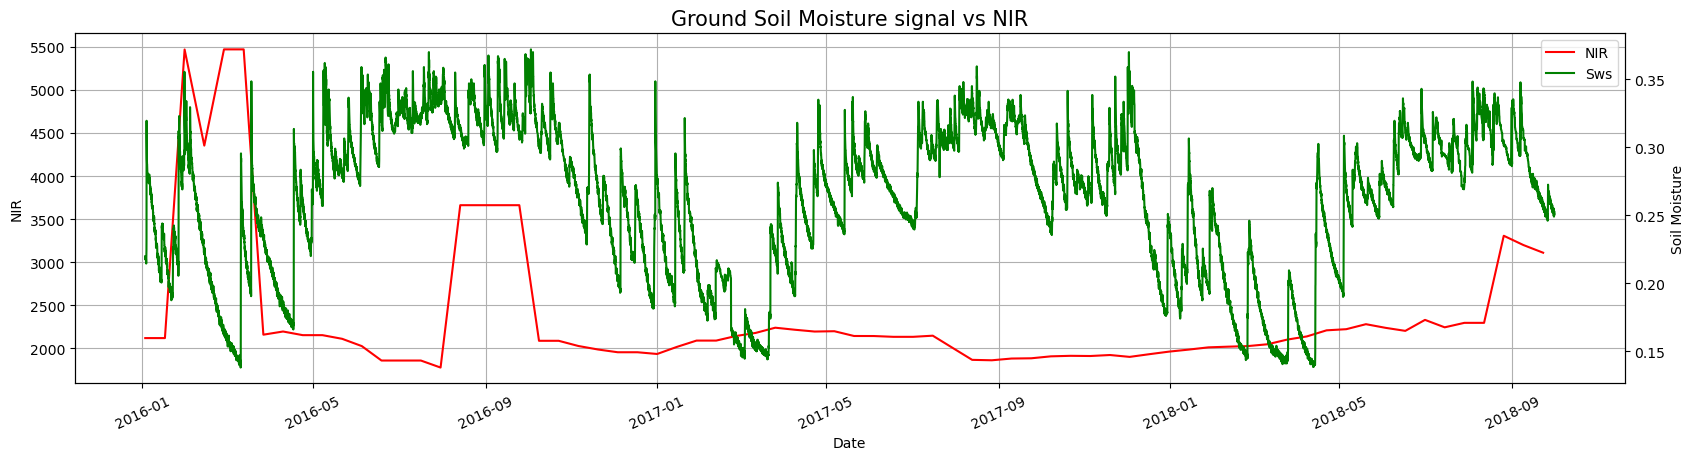

In [15]:
xarr = NIR_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2016-01','2018-09-30'))

x = selection['index']
x2 = ds_01_18['date'].iloc[130272:]
y1 = selection['NIR']
y2 = ds_01_18['Sws'].iloc[130272:]

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "NIR")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('NIR')
plt.title('Ground Soil Moisture signal vs NIR', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
#plt.grid()

plt.show()

### NIR with Ground Sensed Soil Moisture 2019 - 2020

Plot: 


/tmp/ipykernel_416/129434891.py:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')


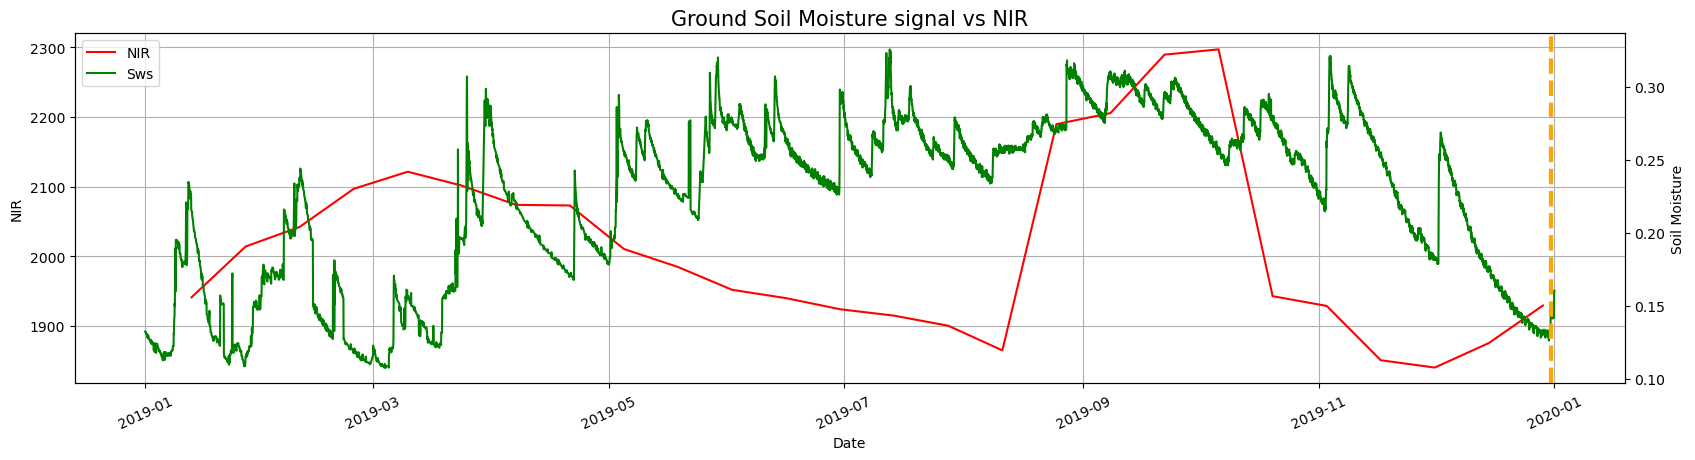

In [16]:
xarr = NIR_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2019-01','2020-01-01'))

x = selection['index']
x2 = ds_2019['date']
y1 = selection['NIR']
y2 = ds_2019['Sws']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "NIR")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('NIR')
plt.title('Ground Soil Moisture signal vs NIR', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
#plt.grid()

plt.show()

### SWIR with Ground Sensed Soil Moisture 2016 - 2018

Plot: 


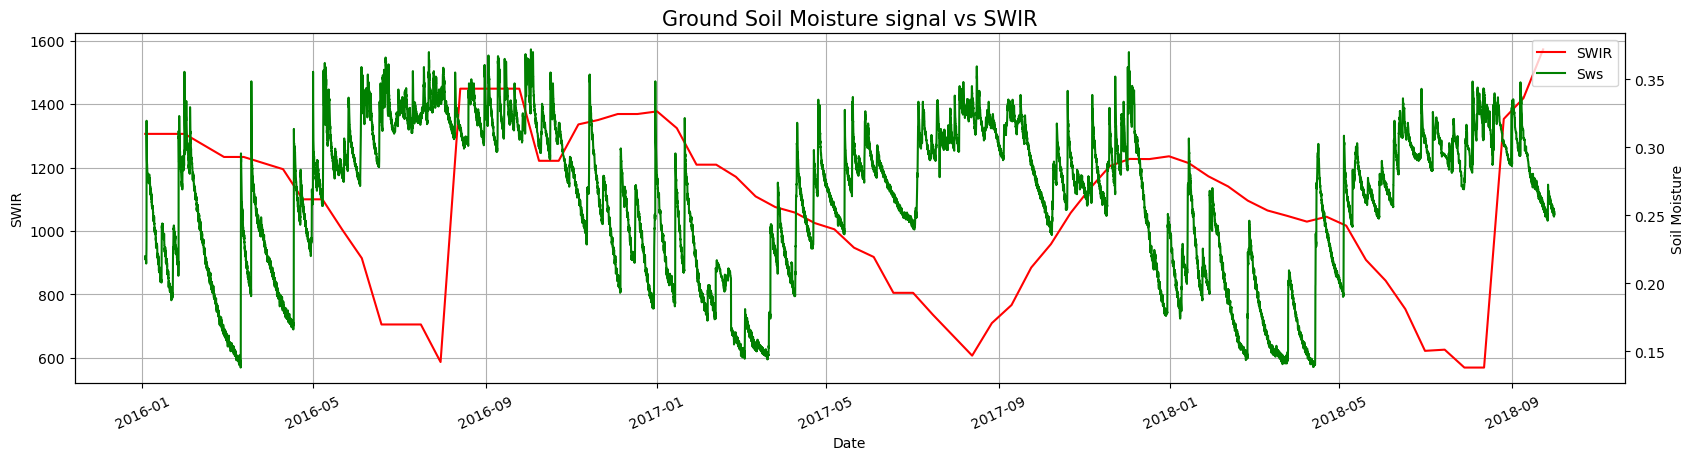

In [17]:
xarr = SWIR_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2016-01','2018-09-30'))

x = selection['index']
x2 = ds_01_18['date'].iloc[130272:]
y1 = selection['SWIR']
y2 = ds_01_18['Sws'].iloc[130272:]

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "SWIR")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('SWIR')
plt.title('Ground Soil Moisture signal vs SWIR', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
#plt.grid()

plt.show()

### SWIR with Ground Sensed Soil Moisture 2019 - 2020

Plot: 


/tmp/ipykernel_416/173801614.py:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')


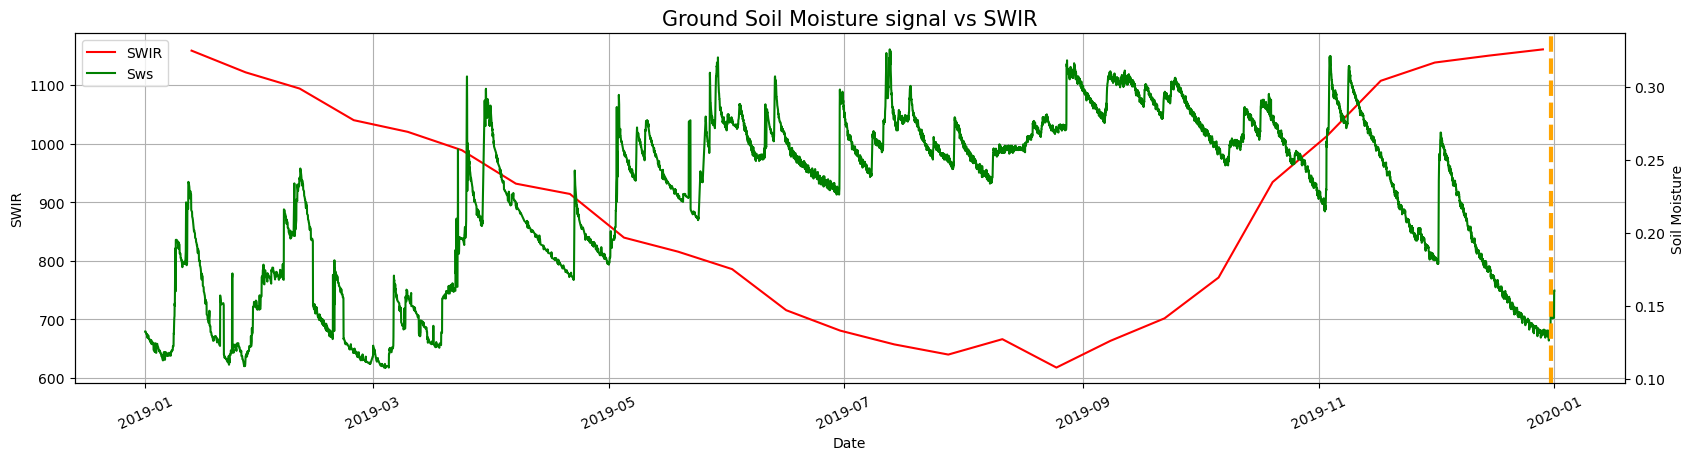

In [18]:
xarr = SWIR_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2019-01','2020-01-01'))

x = selection['index']
x2 = ds_2019['date']
y1 = selection['SWIR']
y2 = ds_2019['Sws']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "SWIR")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('SWIR')
plt.title('Ground Soil Moisture signal vs SWIR', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
#plt.grid()

plt.show()

#### EVI with Ground Sensed Precipitation 2016 - 2018

#### EVI with Ground Sensed Precipitation 2019 - 2020

Plot: 


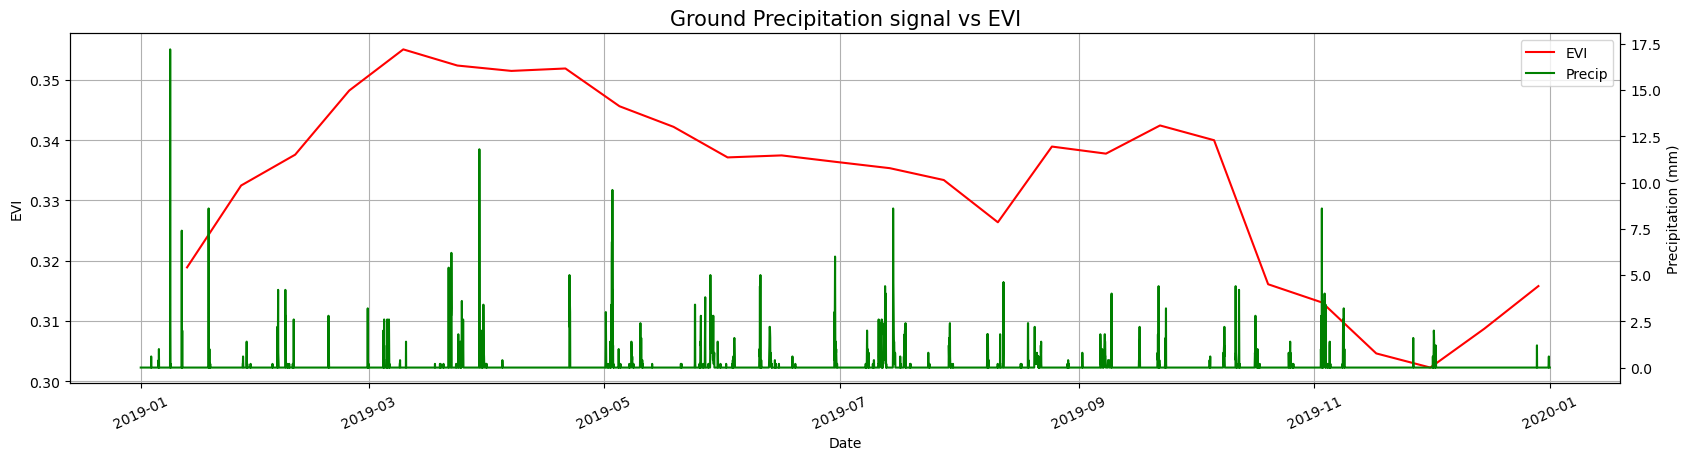

In [19]:
xarr = EVI_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2019-01','2020-01-01'))

x = selection['index']
x2 = ds_2019['date']
y1 = selection['EVI']
y2 = ds_2019['Precip']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "EVI")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('EVI')
plt.title('Ground Precipitation signal vs EVI', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Precip") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend(handles=[line1, line2])
#plt.grid()

plt.show()

#### NIR with Ground Sensed Precipitation

Plot: 


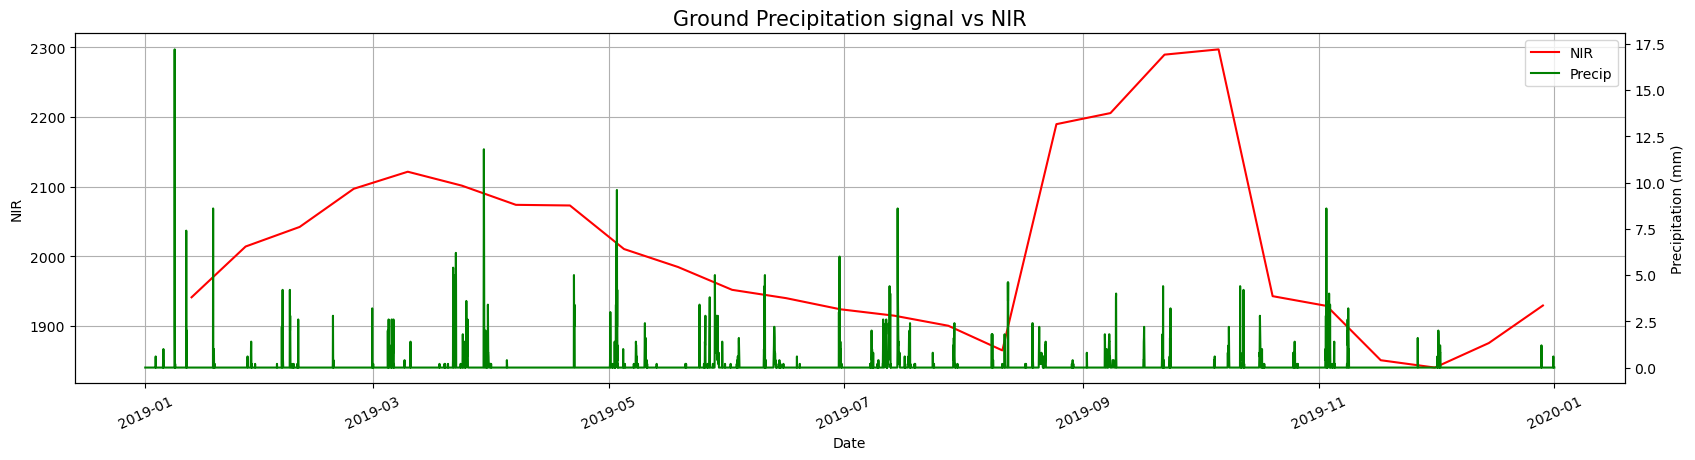

In [20]:
xarr = NIR_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2019-01','2020-01-01'))

x = selection['index']
x2 = ds_2019['date']
y1 = selection['NIR']
y2 = ds_2019['Precip']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "NIR")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('NIR')
plt.title('Ground Precipitation signal vs NIR', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Precip") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend(handles=[line1, line2])
#plt.grid()

plt.show()

# SENTINEL 1 COMPARISON SOIL MOISTURE

### VH with Ground Sensed Soil Moisture 2016-2018

Plot: 


/tmp/ipykernel_416/950761775.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_SwS_16_18_v2.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_416/950761775.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_SwS_16_18_v2.jpg', dpi=400, facecolor='w', edgecolor='w',


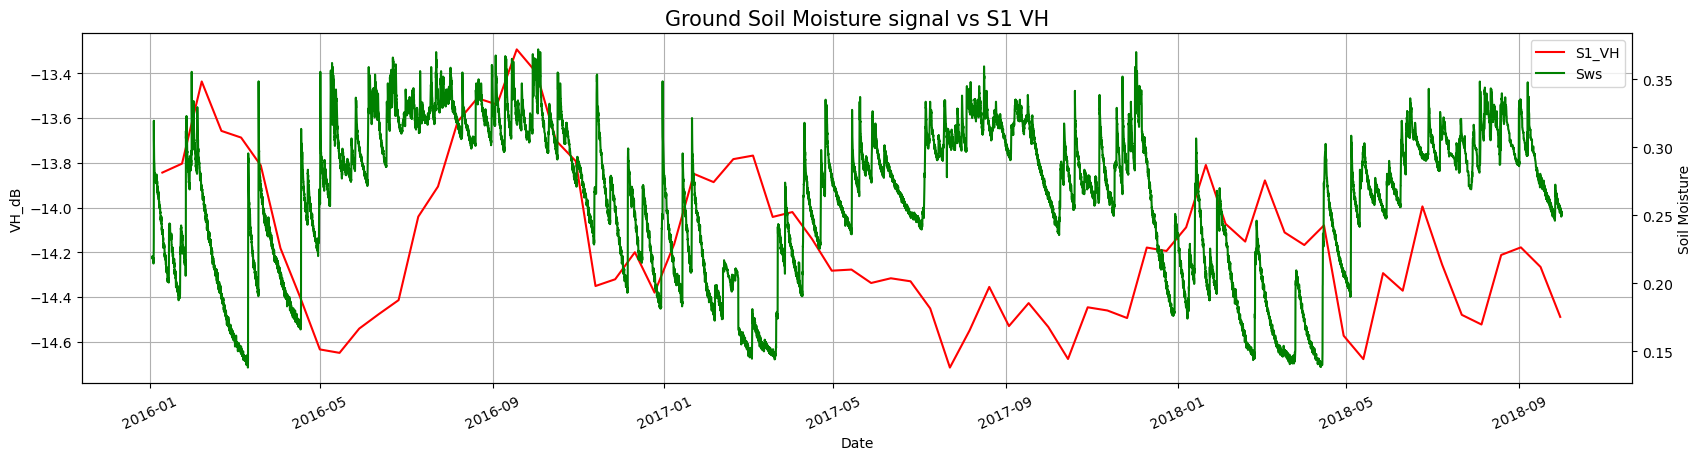

In [21]:
mask1 = (VH_smooth_df['time'] > '2016-01') & (VH_smooth_df['time'] <= '2018-09-30')
selection = VH_smooth_df.loc[mask1]

x = selection['time']
x2 = ds_01_18['date'].iloc[130272:]
y1 = selection['vh_dB']
y2 = ds_01_18['Sws'].iloc[130272:]
mask2 = (VH_smooth_std['time'] > '2016-01') & (VH_smooth_std['time'] <= '2018-09-30')
STD_sel = VH_smooth_std.loc[mask2]
STD = STD_sel['vh_dB']


f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VH")   
#plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VH_dB')
plt.title('Ground Soil Moisture signal vs S1 VH', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])

plt.savefig(fname='S1_VH_SwS_16_18_v2.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

### VH with Ground Sensed Soil Moisture 2019 - 2020

Plot: 


/tmp/ipykernel_416/3838094348.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_416/3838094348.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_SwS_19_20_v2.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_416/3838094348.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_SwS_19_20_v2.jpg', dpi=400, facecolor='w', edgecolor='w',


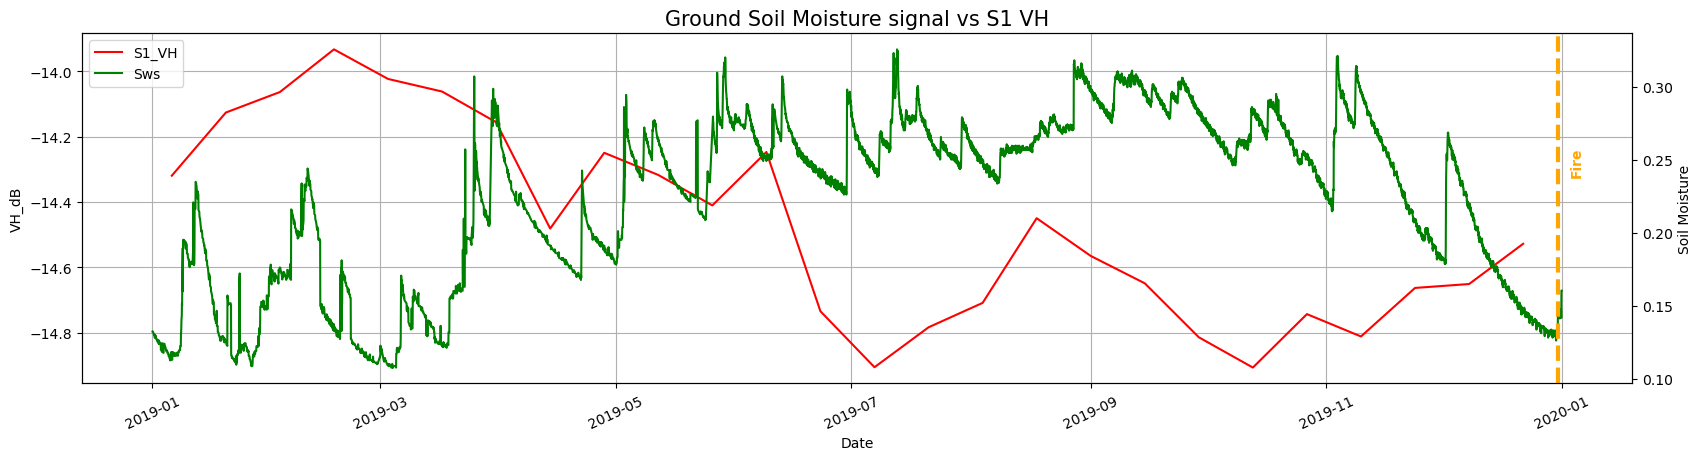

In [22]:
mask1 = (VH_smooth_df['time'] > '2019-01') & (VH_smooth_df['time'] <= '2020-01-01')
selection = VH_smooth_df.loc[mask1]

x = selection['time']
x2 = ds_2019['date']
y1 = selection['vh_dB']
y2 = ds_2019['Sws']
mask2 = (VH_smooth_std['time'] > '2019-01') & (VH_smooth_std['time'] <= '2020-01-01')
STD_sel = VH_smooth_std.loc[mask2]
STD = STD_sel['vh_dB']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VH")
#plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VH_dB')
plt.title('Ground Soil Moisture signal vs S1 VH', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')

x_text_annotation = dt.datetime(2020,1,3)
plt.text(x=x_text_annotation, y=0.24, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')

plt.savefig(fname='S1_VH_SwS_19_20_v2.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

### VV with Ground Sensed Soil Moisture 2016-2018

Plot: 


/tmp/ipykernel_416/1165985358.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_SwS_16_18.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_416/1165985358.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_SwS_16_18.jpg', dpi=400, facecolor='w', edgecolor='w',


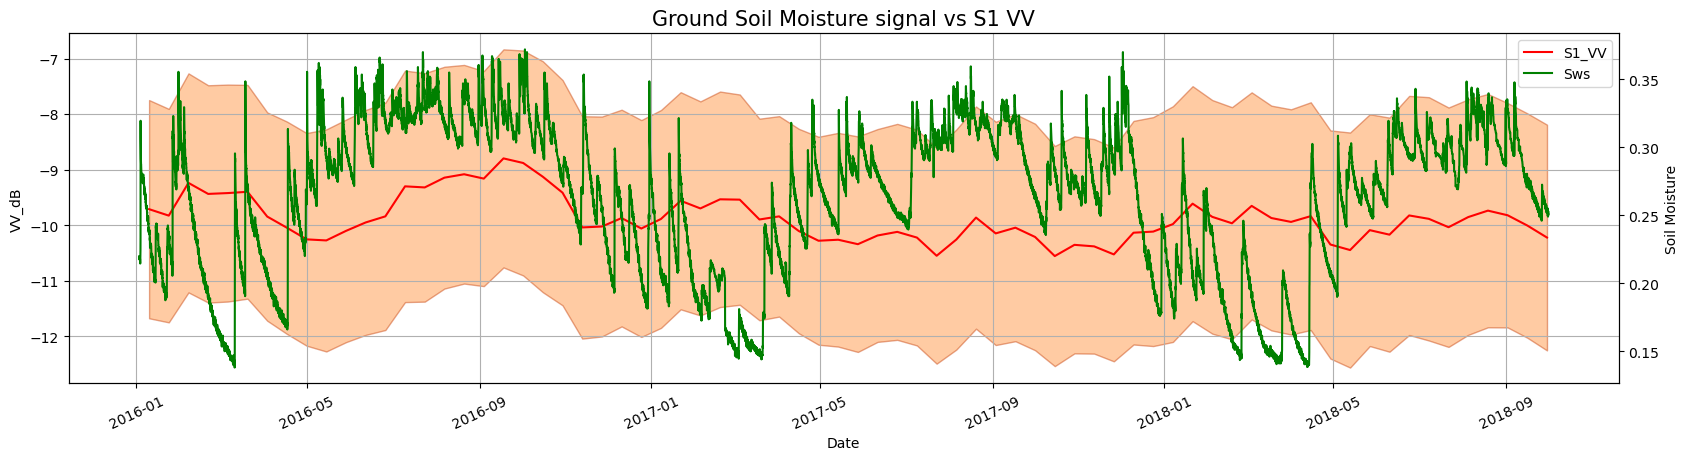

In [23]:
mask1 = (VV_smooth_df['time'] > '2016-01') & (VV_smooth_df['time'] <= '2018-09-30')
selection = VV_smooth_df.loc[mask1]

x = selection['time']
x2 = ds_01_18['date'].iloc[130272:]
y1 = selection['vv_dB']
y2 = ds_01_18['Sws'].iloc[130272:]
mask2 = (VH_smooth_std['time'] > '2016-01') & (VH_smooth_std['time'] <= '2018-09-30')
STD_sel = VH_smooth_std.loc[mask2]
STD = STD_sel['vh_dB']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VV")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VV_dB')
plt.title('Ground Soil Moisture signal vs S1 VV', fontsize = 15)
plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])

plt.savefig(fname='S1_VV_SwS_16_18.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

### VV with Ground Sensed Soil Moisture 2019 - 2020

Plot: 


/tmp/ipykernel_416/2878535099.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_416/2878535099.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_SwS_19_20.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_416/2878535099.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_SwS_19_20.jpg', dpi=400, facecolor='w', edgecolor='w',


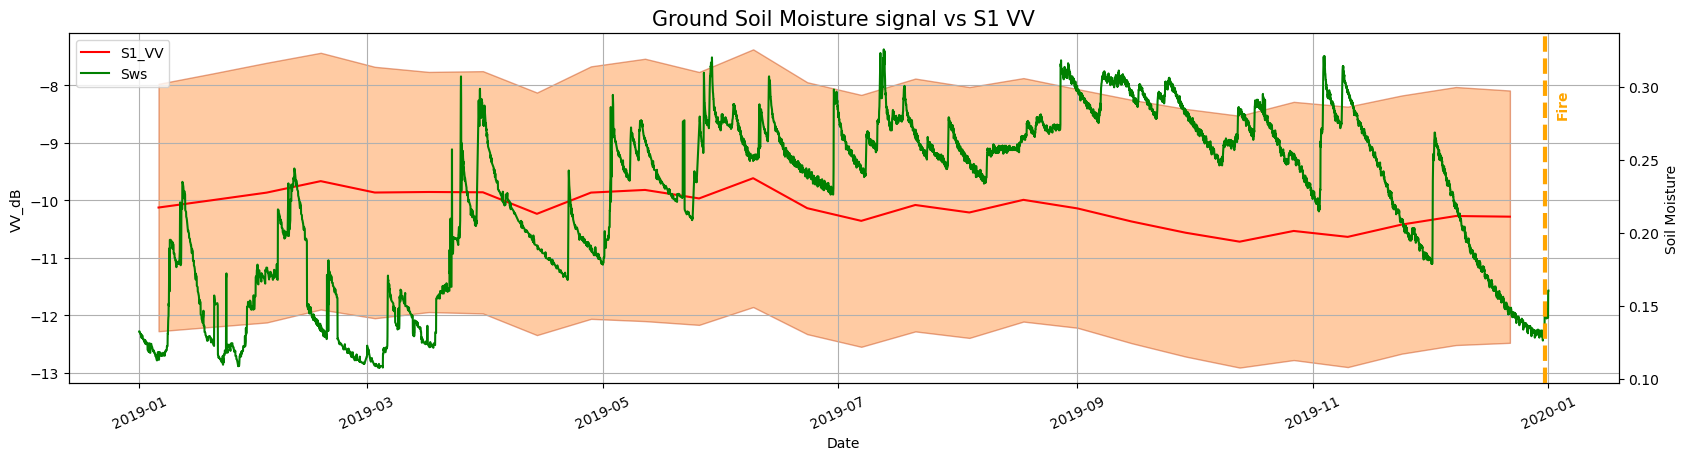

In [24]:
mask1 = (VV_smooth_df['time'] > '2019-01') & (VV_smooth_df['time'] <= '2020-01-01')
selection = VV_smooth_df.loc[mask1]

x = selection['time']
x2 = ds_2019['date']
y1 = selection['vv_dB']
y2 = ds_2019['Sws']
mask2 = (VH_smooth_std['time'] > '2019-01') & (VH_smooth_std['time'] <= '2020-01-01')
STD_sel = VH_smooth_std.loc[mask2]
STD = STD_sel['vh_dB']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VV")  
plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VV_dB')
plt.title('Ground Soil Moisture signal vs S1 VV', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')

x_text_annotation = dt.datetime(2020,1,3)
plt.text(x=x_text_annotation, y=0.28, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')

plt.savefig(fname='S1_VV_SwS_19_20.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

### VV/VH with Ground Sensed Soil Moisture 2016-2018

Plot: 


/tmp/ipykernel_399/4031964305.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_SwS_16_18.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_399/4031964305.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_SwS_16_18.jpg', dpi=400, facecolor='w', edgecolor='w',


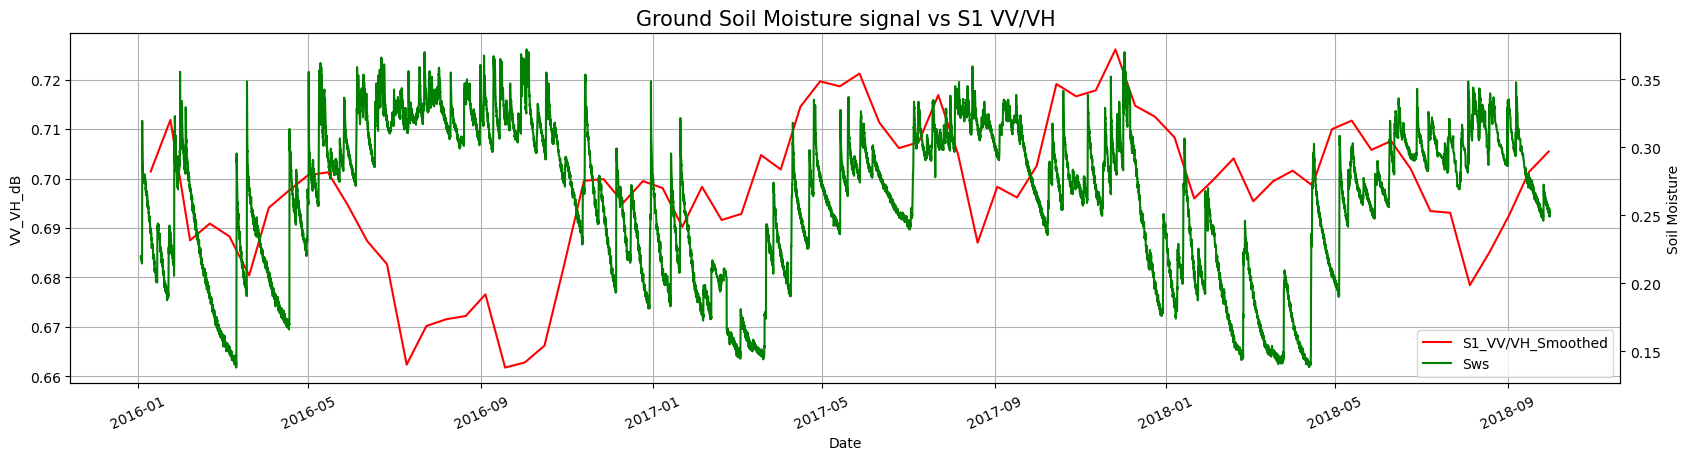

In [13]:
mask1 = (VV_VH_df['time'] > '2016-01') & (VH_smooth_df['time'] <= '2018-09-30')
selection = VV_VH_df.loc[mask1]

x = selection['time']
x2 = ds_01_18['date'].iloc[130272:]
y1 = selection['VV_VH']
y2 = ds_01_18['Sws'].iloc[130272:]
#mask2 = (VH_smooth_std['time'] > '2016-01') & (VH_smooth_std['time'] <= '2018-09-30')
#STD_sel = VH_smooth_std.loc[mask2]
#STD = STD_sel['vh_dB']


f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VV/VH_Smoothed")   
#plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VV_VH_dB')
plt.title('Ground Soil Moisture signal vs S1 VV/VH', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])

plt.savefig(fname='S1_VV_VH_SwS_16_18.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

### VV/VH with Ground Sensed Soil Moisture 2019 - 2020

Plot: 


/tmp/ipykernel_416/4124588216.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_416/4124588216.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_SwS_19_20.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_416/4124588216.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_SwS_19_20.jpg', dpi=400, facecolor='w', edgecolor='w',


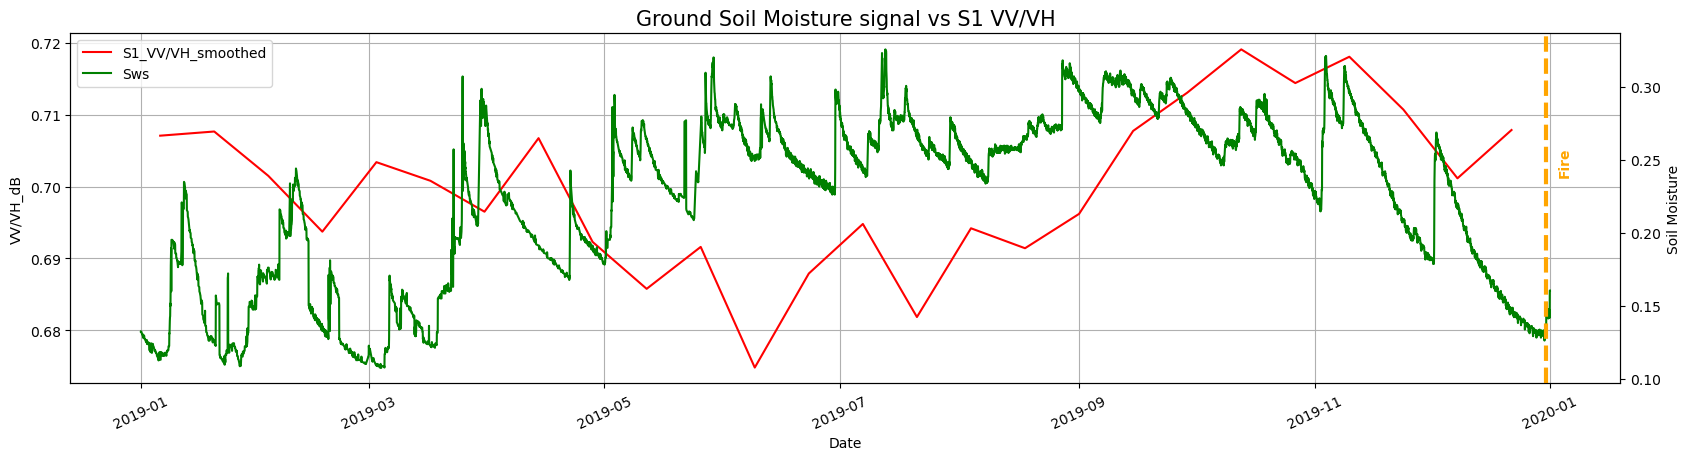

In [40]:
mask1 = (VV_VH_df['time'] > '2019-01') & (VH_smooth_df['time'] <= '2020-01-01')
selection = VV_VH_df.loc[mask1]

x = selection['time']
x2 = ds_2019['date']
y1 = selection['VV_VH']
y2 = ds_2019['Sws']
#mask2 = (VH_smooth_std['time'] > '2019-01') & (VH_smooth_std['time'] <= '2020-01-01')
#STD_sel = VH_smooth_std.loc[mask2]
#STD = STD_sel['vh_dB']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VV/VH_smoothed")
#plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VV/VH_dB')
plt.title('Ground Soil Moisture signal vs S1 VV/VH', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g', linestyle = 'solid',label = "Sws") 
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend(handles=[line1, line2])
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')

x_text_annotation = dt.datetime(2020,1,3)
plt.text(x=x_text_annotation, y=0.24, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')

plt.savefig(fname='S1_VV_VH_SwS_19_20.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

# SENTINEL 1 COMPARISON LEAF AREA INDEX (LAI)

#### Working with data to achieve correct format

In [14]:
single_time_df = PAI_2019_df.iloc[:,2:].rolling(window=2).mean()[1::2]  # site ave for both plots
single_time_df.to_xarray()
single_time_df['time'] = pd.to_datetime(PAI_2019_df['time'],dayfirst=True)

/tmp/ipykernel_399/2568718752.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['time'], dtype='object')
  single_time_df = PAI_2019_df.iloc[:,2:].rolling(window=2).mean()[1::2]  # site ave for both plots


Selecting two sections of the LAI for a line plot

In [15]:
PreFire = single_time_df.iloc[0:5]
PstFire = single_time_df.iloc[5:]

### VH comparison to LAI

In [16]:
import numpy.ma as ma

Plot: 


/tmp/ipykernel_398/1343878602.py:46: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_398/1343878602.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_LAI.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_398/1343878602.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_LAI.jpg', dpi=400, facecolor='w', edgecolor='w',


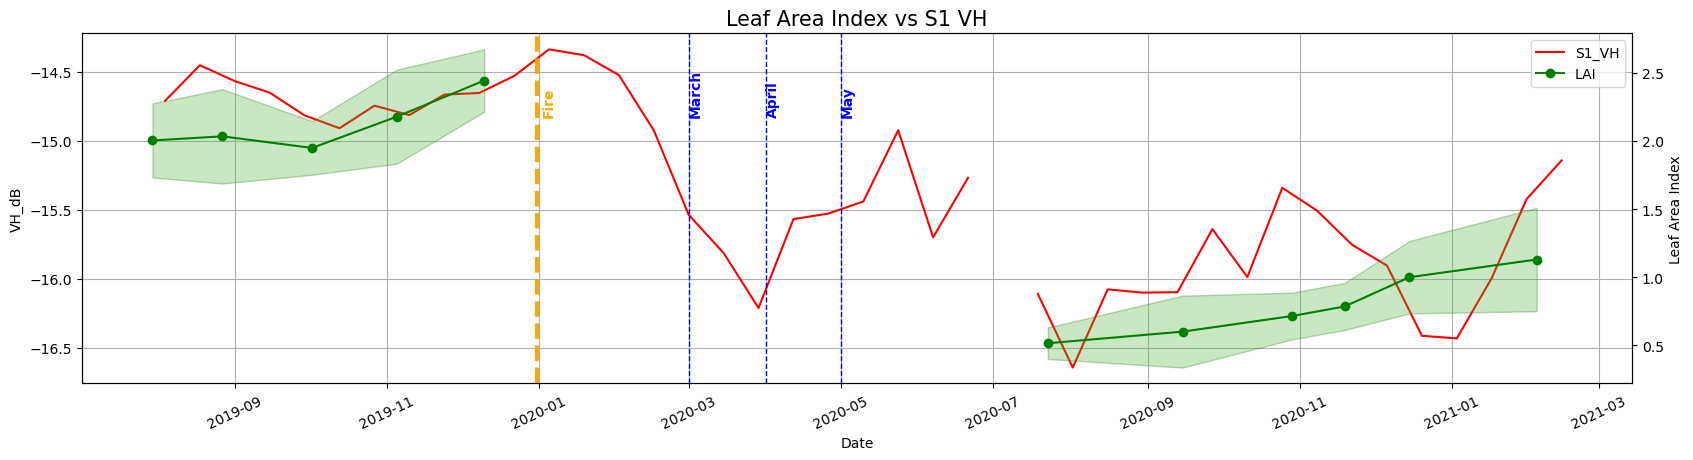

In [43]:
mask1 = (VH_smooth_df['time'] > '2019-07-21') & (VH_smooth_df['time'] <= '2021-02-14')
selection = VH_smooth_df.loc[mask1]
#xarr = VH_smooth_df.to_xarray()
#xarr = xarr.set_index(index = 'time')
#selection = xarr.sel(index = slice('2019-07-21','2021-02-14'))

x = selection['time']
x2 = PreFire['time']
x3 = PstFire['time']
y1 = selection['vh_dB']
y2 = PreFire['PAI_clx']
y3 = PstFire['PAI_clx']
mask2 = (VH_smooth_std['time'] > '2019-01') & (VH_smooth_std['time'] <= '2020-01-01')
STD_sel = VH_smooth_std.loc[mask2]
STD = STD_sel['vh_dB']                                              
STD2 = PreFire['PAI_SD']
STD3 = PstFire['PAI_SD']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VH") 
#plt.fill_between(x, y1-STD, y1+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VH_dB')
plt.title('Leaf Area Index vs S1 VH', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g',marker = 'o',label = "LAI") 
plt.fill_between(x2, y2-STD2, y2+STD2, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
line3, = plt.plot(x3, y3, color = 'g',marker = 'o') 
plt.fill_between(x3, y3-STD3, y3+STD3, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Leaf Area Index')
plt.legend(handles=[line1, line2])
# Vertical Lines
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2020-03-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-04-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-05-01'),lw=1,c='blue',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,2)
plt.text(x=x_text_annotation, y=2.2, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,3,1)
plt.text(x=x_text_annotation6, y=2.2, s='March', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,4,1)
plt.text(x=x_text_annotation6, y=2.2, s='April', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,5,1)
plt.text(x=x_text_annotation6, y=2.2, s='May', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')

plt.savefig(fname='S1_VH_LAI.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

### VV Comparions to LAI

Plot: 


/tmp/ipykernel_416/2519317928.py:39: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_416/2519317928.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_LAI.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_416/2519317928.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_LAI.jpg', dpi=400, facecolor='w', edgecolor='w',


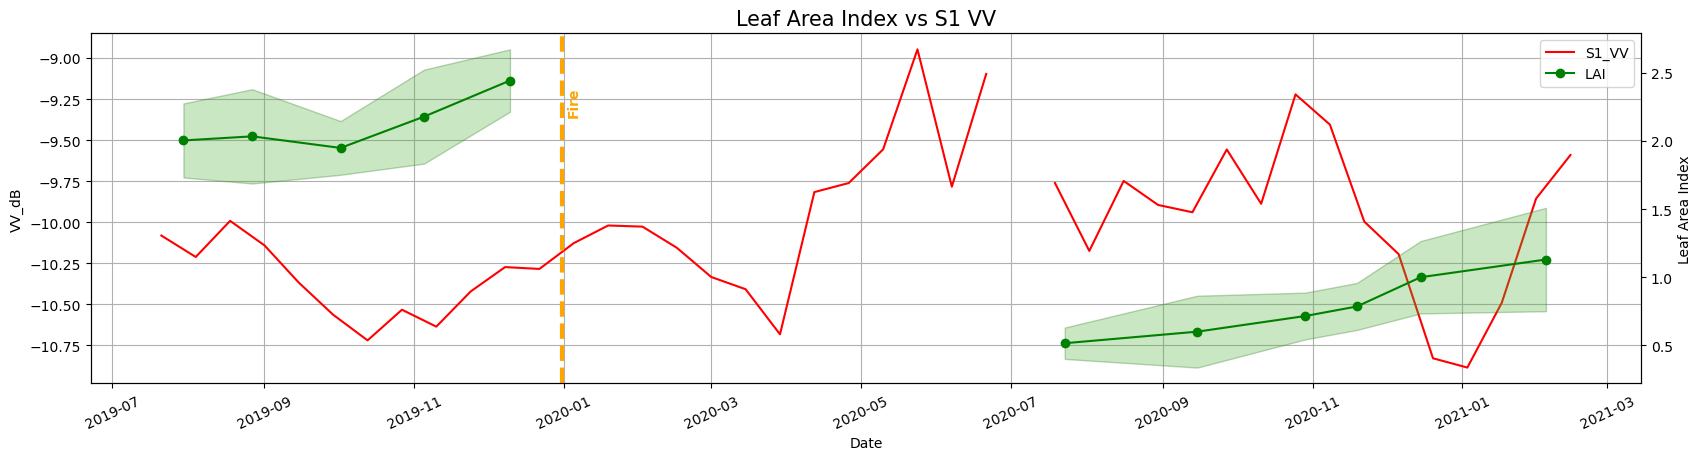

In [34]:
xarr = VV_smooth_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2019-07-21','2021-02-14'))

x = selection['index']
x2 = PreFire['time']
x3 = PstFire['time']
y1 = selection['vv_dB']
y2 = PreFire['PAI_clx']
y3 = PstFire['PAI_clx']
STD2 = PreFire['PAI_SD']
STD3 = PstFire['PAI_SD']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VV")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VV_dB')
plt.title('Leaf Area Index vs S1 VV', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g',marker = 'o',label = "LAI") 
plt.fill_between(x2, y2-STD2, y2+STD2, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
line3, = plt.plot(x3, y3, color = 'g',marker = 'o') 
plt.fill_between(x3, y3-STD3, y3+STD3, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Leaf Area Index')
plt.legend(handles=[line1, line2])
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,2)
plt.text(x=x_text_annotation, y=2.2, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')

plt.savefig(fname='S1_VV_LAI.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

### VV/VH Comparison to LAI

Plot: 


/tmp/ipykernel_399/3965738030.py:39: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_399/3965738030.py:53: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_LAI.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_399/3965738030.py:53: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_LAI.jpg', dpi=400, facecolor='w', edgecolor='w',


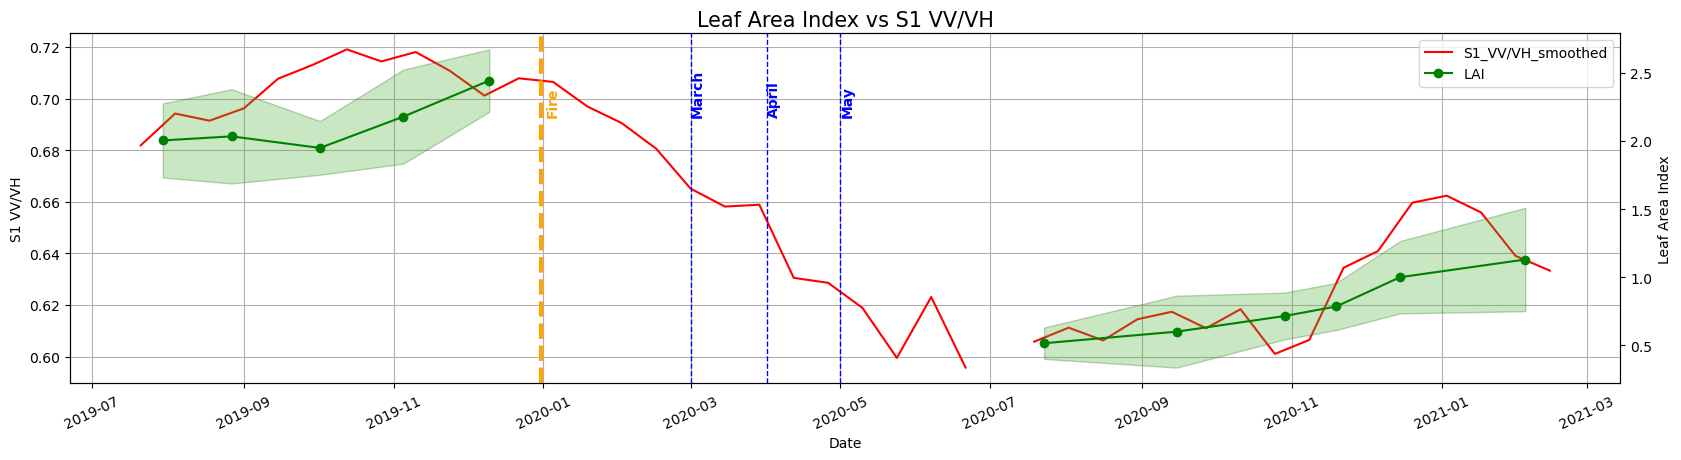

In [17]:
xarr = VV_VH_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2019-07-21','2021-02-14'))

x = selection['index']
x2 = PreFire['time']
x3 = PstFire['time']
y1 = selection['VV_VH']
y2 = PreFire['PAI_clx']
y3 = PstFire['PAI_clx']
STD2 = PreFire['PAI_SD']
STD3 = PstFire['PAI_SD']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VV/VH_smoothed")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('S1 VV/VH')
plt.title('Leaf Area Index vs S1 VV/VH', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

#plt.subplot(212)
plt.twinx()
line2, = plt.plot(x2, y2, color = 'g',marker = 'o',label = "LAI") 
plt.fill_between(x2, y2-STD2, y2+STD2, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
line3, = plt.plot(x3, y3, color = 'g',marker = 'o') 
plt.fill_between(x3, y3-STD3, y3+STD3, alpha=0.3, edgecolor='#2c781c', facecolor='#4eb038')
plt.xticks(rotation = 25)
#plt.xlabel('Date')
plt.ylabel('Leaf Area Index')
plt.legend(handles=[line1, line2])
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2020-03-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-04-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-05-01'),lw=1,c='blue',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,2)
plt.text(x=x_text_annotation, y=2.2, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,3,1)
plt.text(x=x_text_annotation6, y=2.2, s='March', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,4,1)
plt.text(x=x_text_annotation6, y=2.2, s='April', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,5,1)
plt.text(x=x_text_annotation6, y=2.2, s='May', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')

plt.savefig(fname='S1_VV_VH_LAI.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

# Sentinel 1 Comparison Phenocam Greeness (GCC)

In [18]:
""" read in pre-computed GCC timeseries """

gcc_df = pd.read_csv('gcc_df_all.csv')

gcc_df.insert(loc=0,column='dt_fmt',value=pd.to_datetime(gcc_df['dt']))

In [19]:
gcc_df.index = gcc_df['dt_fmt']

In [20]:
type(gcc_df)

pandas.core.frame.DataFrame

In [21]:
## Mathcing Data with S timeseries
start_date = '2016-01-10'
end_date = '2020-06-01'
# Select DataFrame rows between two dates
mask = (gcc_df['dt_fmt'] > start_date) & (gcc_df['dt_fmt'] <= end_date)
gcc_df2 = gcc_df.loc[mask]

### VH Comparison GCC

Plot: 


/tmp/ipykernel_398/1429114806.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_398/1429114806.py:51: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_PhenGreen.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_398/1429114806.py:51: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_PhenGreen.jpg', dpi=400, facecolor='w', edgecolor='w',


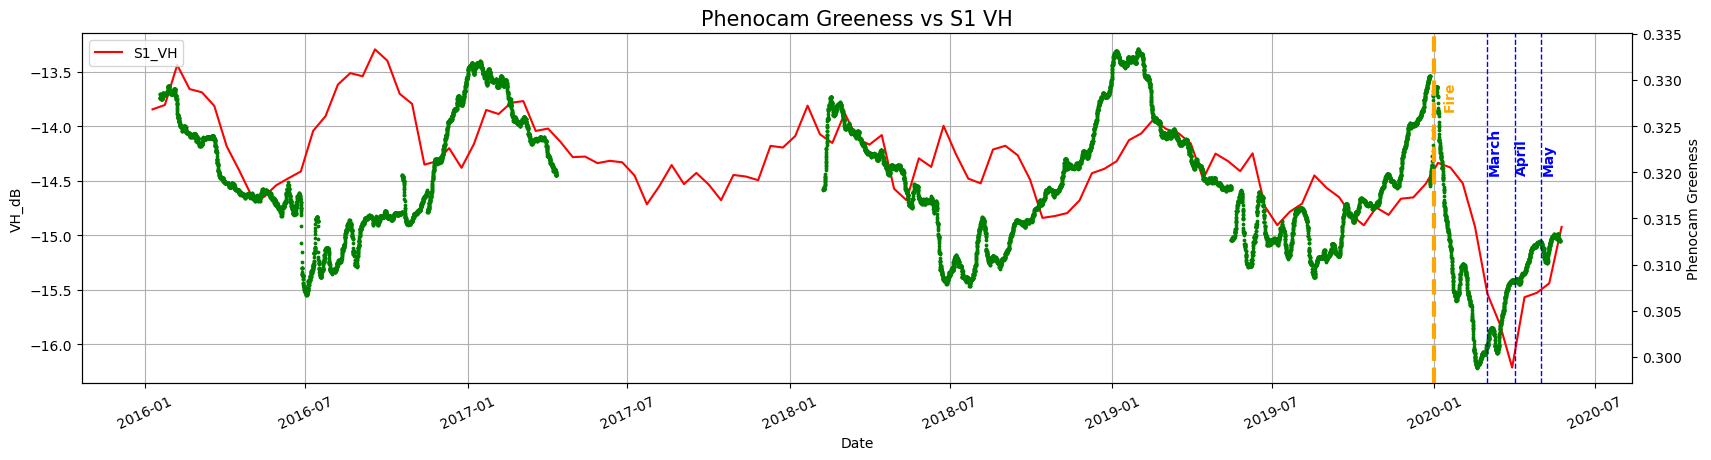

In [24]:
xarr = VH_smooth_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2016-01-10','2020-06-01'))
window_size=100

x = selection['index']
x2 = gcc_df2['dt_fmt']
y1 = selection['vh_dB']
y2 = gcc_df2['gcc'].rolling(window=window_size).median().values
#STD2 = single_time_df['PAI_SD']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VH")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VH_dB')
plt.title('Phenocam Greeness vs S1 VH', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

plt.subplot(211)
plt.twinx()
plt.scatter(x2, y2,s=3, color = 'g',label = "GCC") 

plt.xticks(rotation = 25)
plt.ylabel('Phenocam Greeness')
plt.legend(handles=[line1])

plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2020-03-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-04-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-05-01'),lw=1,c='blue',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=0.327, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,3,1)
plt.text(x=x_text_annotation6, y=0.32, s='March', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,4,1)
plt.text(x=x_text_annotation6, y=0.32, s='April', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,5,1)
plt.text(x=x_text_annotation6, y=0.32, s='May', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')



plt.savefig(fname='S1_VH_PhenGreen.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

Notes:
Looking at GCC anf S1 there does not seem to be any visual correlation between the two datasets. I would not expect there to be any correlation until after ther fire. which there seems to be. this is because the top story of the trees has now disappeared and the radar can picl up more of the greenenss that the Phenocam sees.

*** this seems to only be reflected most in the horizontal return *** 

to me the VH dataset is the most responsive to the vegetation change. maybe this is because VH is more responsive to volume scattering than VV which is responsive to rough surface scattering. It would be good to have a HH response as we might get more correlation with double bounce effect combined with volume?

### VV Comparison GCC

Plot: 


/tmp/ipykernel_384/178135978.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')


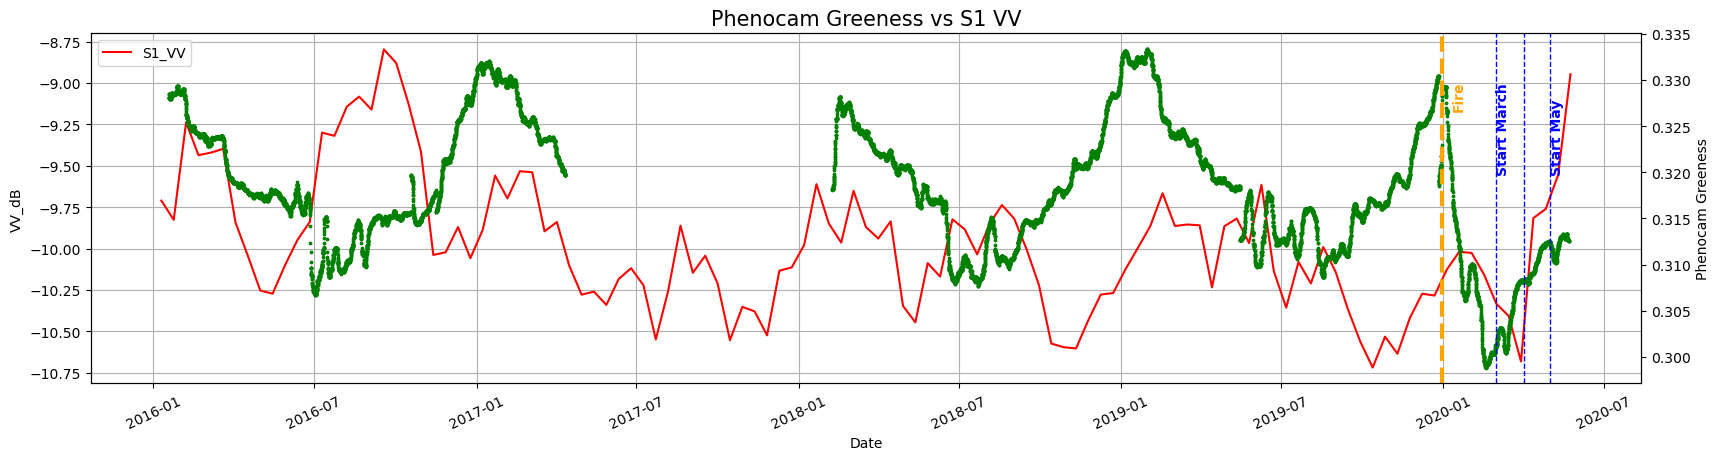

In [32]:
xarr = VV_smooth_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2016-01-10','2020-06-01'))

window_size=100

x = selection['index']
x2 = gcc_df2['dt_fmt']
y1 = selection['vv_dB']
y2 = gcc_df2['gcc'].rolling(window=window_size).median().values
#STD2 = single_time_df['PAI_SD']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VV")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VV_dB')
plt.title('Phenocam Greeness vs S1 VV', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

plt.subplot(211)
plt.twinx()
plt.scatter(x2, y2,s=3, color = 'g',label = "GCC") 
plt.xticks(rotation = 25)
plt.ylabel('Phenocam Greeness')
plt.legend(handles=[line1])

plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2020-03-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-04-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-05-01'),lw=1,c='blue',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=0.327, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,3,1)
plt.text(x=x_text_annotation6, y=0.32, s='March', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,4,1)
plt.text(x=x_text_annotation6, y=0.32, s='April', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,5,1)
plt.text(x=x_text_annotation6, y=0.32, s='May', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')

#plt.savefig(fname='S1_VV_PhenGreen.jpg', dpi=400, facecolor='w', edgecolor='w',
    #transparent=False, bbox_inches='tight', pad_inches=0.1,
    #frameon=None, metadata=None)

plt.show()

### VV/VH Comparison GCC

Plot: 


/tmp/ipykernel_398/1695581951.py:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_398/1695581951.py:48: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_PhenGreen.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_398/1695581951.py:48: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_PhenGreen.jpg', dpi=400, facecolor='w', edgecolor='w',


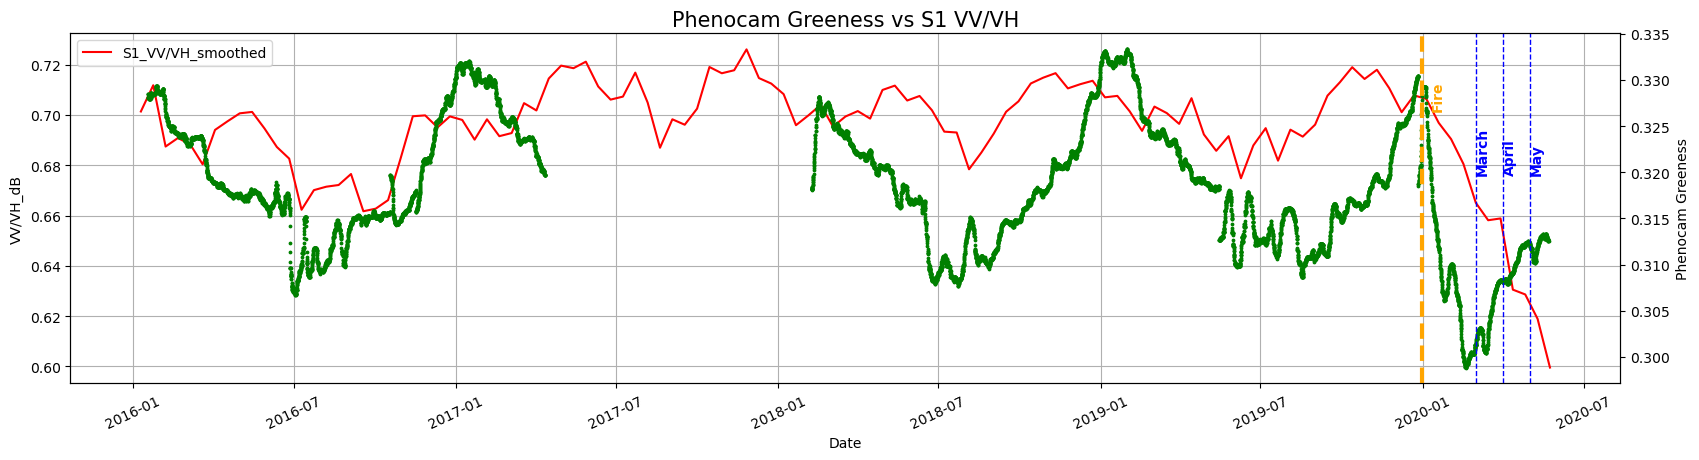

In [23]:
xarr = VV_VH_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2016-01-10','2020-06-01'))

window_size=100

x = selection['index']
x2 = gcc_df2['dt_fmt']
y1 = selection['VV_VH']
y2 = gcc_df2['gcc'].rolling(window=window_size).median().values
#STD2 = single_time_df['PAI_SD']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y1, color = 'r', linestyle = 'solid',label = "S1_VV/VH_smoothed")   
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('VV/VH_dB')
plt.title('Phenocam Greeness vs S1 VV/VH', fontsize = 15)
#plt.legend(handles=[line1])

plt.grid()

plt.subplot(211)
plt.twinx()
plt.scatter(x2, y2,s=3, color = 'g',label = "GCC") 
plt.xticks(rotation = 25)
plt.ylabel('Phenocam Greeness')
plt.legend(handles=[line1])

plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2020-03-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-04-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-05-01'),lw=1,c='blue',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=0.327, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,3,1)
plt.text(x=x_text_annotation6, y=0.32, s='March', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,4,1)
plt.text(x=x_text_annotation6, y=0.32, s='April', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,5,1)
plt.text(x=x_text_annotation6, y=0.32, s='May', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
plt.savefig(fname='S1_VV_VH_PhenGreen.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

plt.show()

## Plotting SIF Data

In [22]:
new_sif_df = pd.read_csv('Tumba_02dist_sif_data_full_2022end.csv', index_col =0 )

SIF: looking at the emitted radiation from the vegetation. SIF is the by product of photosynthesis, the excess enrgy produced after the leaf has photosynthesised. and is released at a specific wavelength. this result is at 743nm wavelength. more of a signal from all vegetation in an area, not just the canopy. 

### Plotting S1 VH/VV combination on SIF

In [13]:
VH_VV_df = VH_smooth_df['vh_dB']/VV_smooth_df['vv_dB']
VH_VV_df = VH_VV_df.to_xarray()
VH_VV_df = VH_VV_df.to_dataframe(name = 'VH_VV')
VH_VV_df['time'] = VH_smooth_df['time']

In [14]:
VV_VH_df = VV_smooth_df['vv_dB']/VH_smooth_df['vh_dB']
VV_VH_df = VV_VH_df.to_xarray()
VV_VH_df = VV_VH_df.to_dataframe(name = 'VV_VH')
VV_VH_df['time'] = VH_smooth_df['time']

In [32]:
VV_VH_df['mov_avg'] = VV_VH_df['VV_VH'].rolling(2).mean()

In [23]:
new_sif_df.index = pd.to_datetime(new_sif_df.index)

In [24]:
mask1 = (new_sif_df.index > '2018-07-10') & (new_sif_df.index <= '2019-12-29')
mask2 = (new_sif_df.index > '2020-01-01') & (new_sif_df.index <= '2021-12-29')

In [70]:
# POST FIRE SIF
#new_sif_xr = new_sif_df.to_xarray()
#PreFire_SIF_xr = new_sif_xr.sel(index = slice('2018-07-10','2019-12-29'))
#PostFire_SIF_xr = new_sif_xr.sel(index = slice('2020-01-01','2021-12-29'))

In [71]:
#PreFire_SIF_df = PreFire_SIF_xr.to_dataframe()
#PostFire_SIF_df = PostFire_SIF_xr.to_dataframe()
#PreFire_SIF_df['mov_avg'] = PreFire_SIF_df['SIF_743'].rolling(8).mean()
#PostFire_SIF_df['mov_avg'] = PostFire_SIF_df['SIF_743'].rolling(8).mean()

In [72]:
#VV_VH_df.to_csv('VV_VH_df.csv', index='time')

# VV/VH SIF FINAL PLOTTING

/tmp/ipykernel_399/104944782.py:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_399/104944782.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_SIF_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_399/104944782.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_SIF_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',


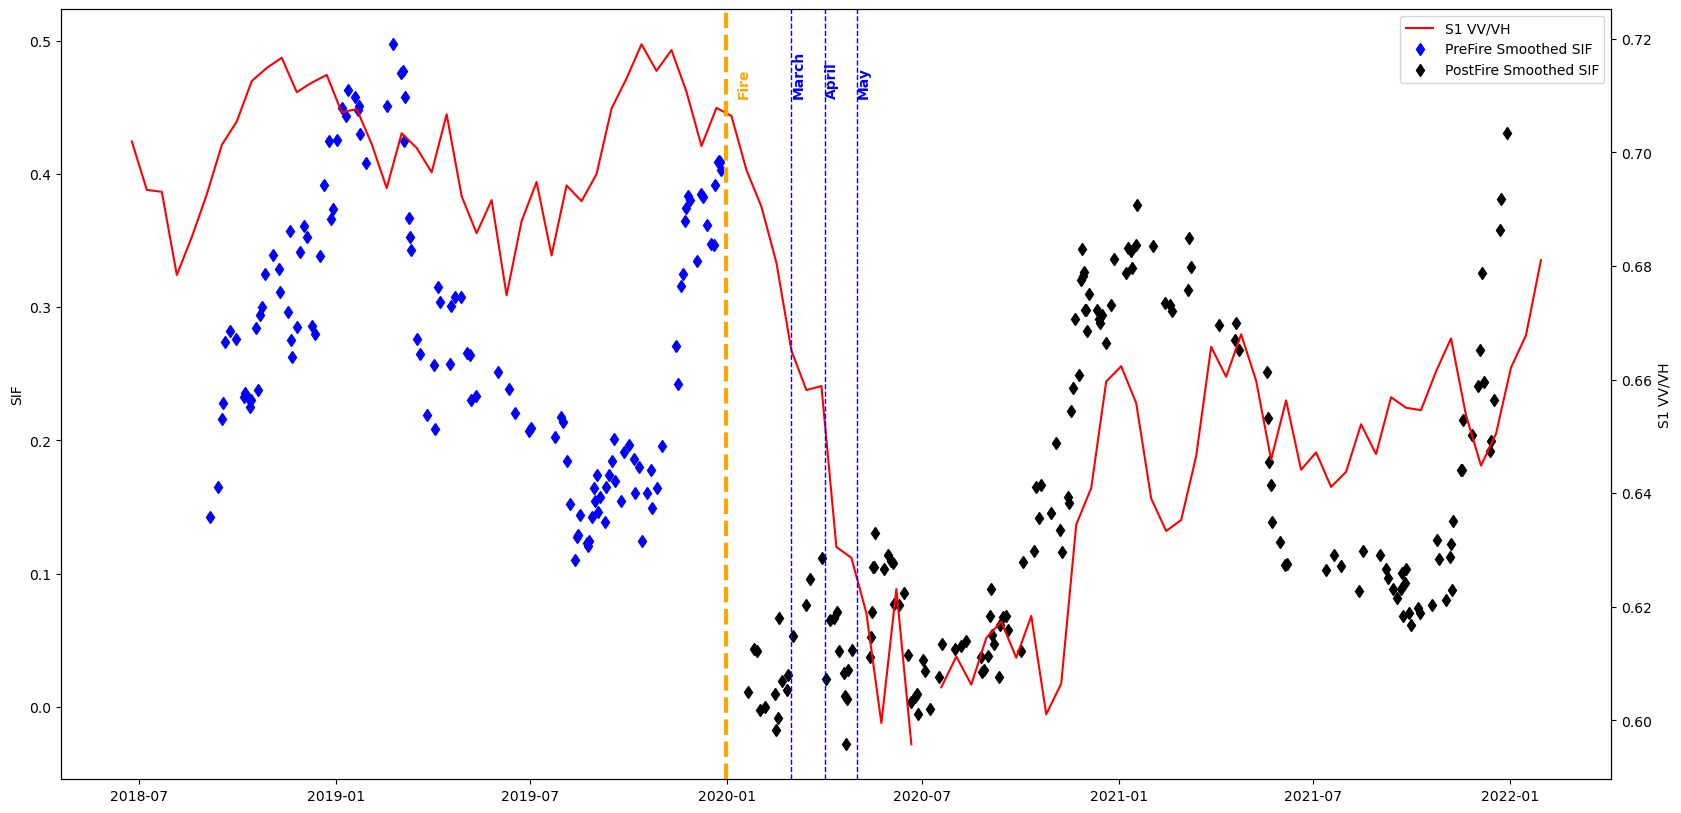

In [30]:
xarr = VV_VH_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2018-06-24','2022-02-03'))
selection_df = selection.to_dataframe()
#x = new_sif_df.index
x2 = selection_df.index
x3 = new_sif_df.loc[mask1].index
x4 = new_sif_df.loc[mask2].index
#y1 = new_sif_df.SIF_743
y2 = selection_df.VV_VH
y3 = new_sif_df.loc[mask1].SIF_743.rolling(8).mean()
y4 = new_sif_df.loc[mask2].SIF_743.rolling(8).mean()

fig, ax = plt.subplots(figsize=(20, 10))

twin1 = ax.twinx()


#p1, = ax.plot(x,y1, 'd', color = 'b',  alpha = 0.2, label='SIF')
p2, = twin1.plot(x2,y2,'r-', label='S1 VV/VH')
p3, = ax.plot(x3,y3, 'd', color = 'b', label='PreFire Smoothed SIF')
p4, = ax.plot(x4,y4, 'd', color = 'k', label='PostFire Smoothed SIF')


ax.set_ylabel("SIF")
twin1.set_ylabel("S1 VV/VH")
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2020-03-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-04-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-05-01'),lw=1,c='blue',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=0.71, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,3,1)
plt.text(x=x_text_annotation6, y=0.71, s='March', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,4,1)
plt.text(x=x_text_annotation6, y=0.71, s='April', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,5,1)
plt.text(x=x_text_annotation6, y=0.71, s='May', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
ax.legend(handles=[p2, p3, p4])

plt.savefig(fname='S1_VV_VH_SIF_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)



# VV SIF FINAL PLOTTING

In [29]:
VV_smooth_df['mov_avg'] = VV_smooth_df['vv_dB'].rolling(2).mean()

/tmp/ipykernel_373/2729955948.py:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_373/2729955948.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_SIF_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_373/2729955948.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_SIF_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',


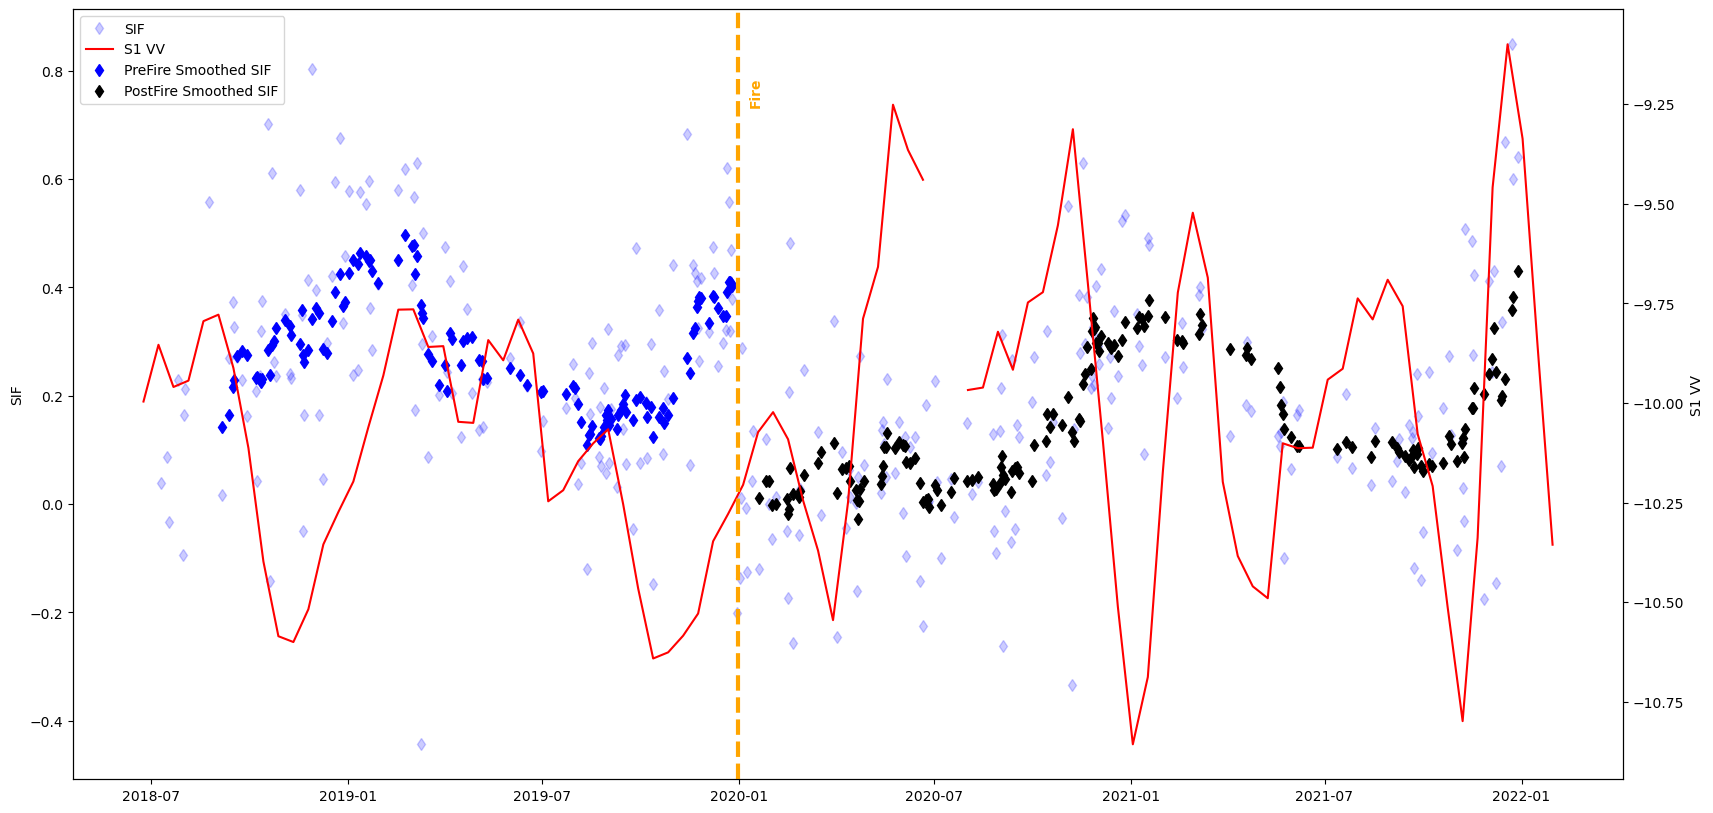

In [78]:
xarr = VV_smooth_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2018-06-24','2022-02-03'))
selection_df = selection.to_dataframe()

x = new_sif_df.index
x2 = selection_df.index
x3 = new_sif_df.loc[mask1].index
x4 = new_sif_df.loc[mask2].index
y1 = new_sif_df.SIF_743
y2 = selection_df.mov_avg
y3 = new_sif_df.loc[mask1].SIF_743.rolling(8).mean()
y4 = new_sif_df.loc[mask2].SIF_743.rolling(8).mean()

fig, ax = plt.subplots(figsize=(20, 10))

twin1 = ax.twinx()

p1, = ax.plot(x,y1, 'd', color = 'b',  alpha = 0.2, label='SIF')
p2, = twin1.plot(x2,y2,'r-', label='S1 VV')
p3, = ax.plot(x3,y3, 'd', color = 'b', label='PreFire Smoothed SIF')
p4, = ax.plot(x4,y4, 'd', color = 'k', label='PostFire Smoothed SIF')

ax.set_ylabel("SIF")
twin1.set_ylabel("S1 VV")
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=-9.25, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')

ax.legend(handles=[p1, p2, p3, p4])

plt.savefig(fname='S1_VV_SIF_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)



# VH SIF FINAL PLOTTING

In [32]:
VH_smooth_df['mov_avg'] = VH_smooth_df['vh_dB'].rolling(2).mean()

/tmp/ipykernel_399/3532509588.py:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_399/3532509588.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_SIF_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_399/3532509588.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_SIF_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',


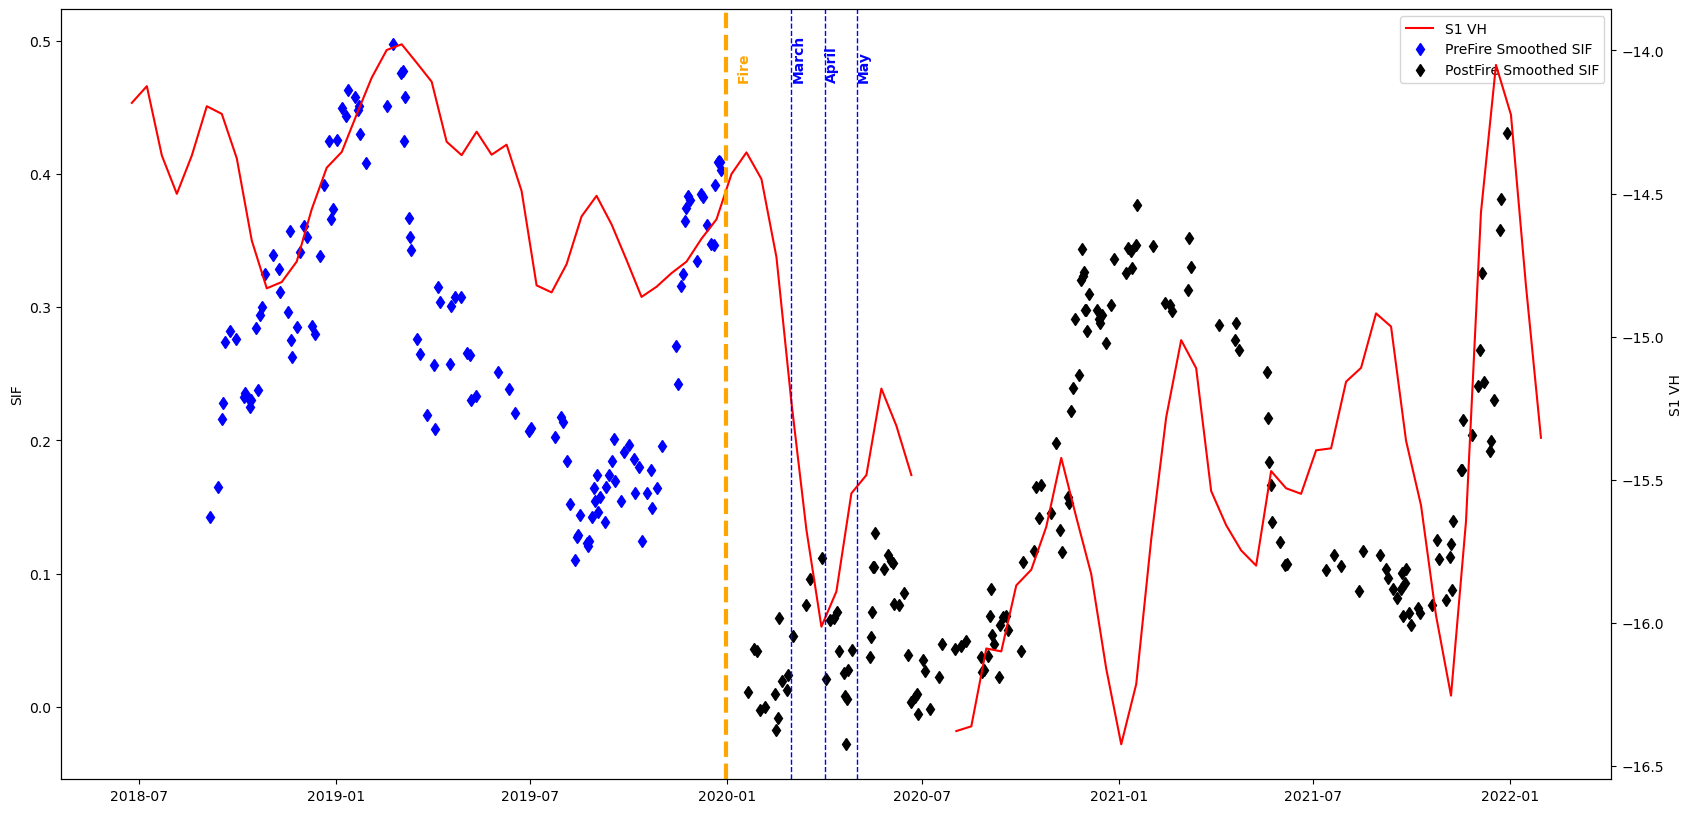

In [33]:
xarr = VH_smooth_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr.sel(index = slice('2018-06-24','2022-02-03'))
selection_df = selection.to_dataframe()

#x = new_sif_df.index
x2 = selection_df.index
x3 = new_sif_df.loc[mask1].index
x4 = new_sif_df.loc[mask2].index
#y1 = new_sif_df.SIF_743
y2 = selection_df.mov_avg
y3 = new_sif_df.loc[mask1].SIF_743.rolling(8).mean()
y4 = new_sif_df.loc[mask2].SIF_743.rolling(8).mean()

fig, ax = plt.subplots(figsize=(20, 10))

twin1 = ax.twinx()


#p1, = ax.plot(x,y1, 'd', color = 'b',  alpha = 0.2, label='SIF')
p2, = twin1.plot(x2,y2,'r-', label='S1 VH')
p3, = ax.plot(x3,y3, 'd', color = 'b', label='PreFire Smoothed SIF')
p4, = ax.plot(x4,y4, 'd', color = 'k', label='PostFire Smoothed SIF')

ax.set_ylabel("SIF")
twin1.set_ylabel("S1 VH")
plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2020-03-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-04-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-05-01'),lw=1,c='blue',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=-14.1, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,3,1)
plt.text(x=x_text_annotation6, y=-14.1, s='March', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,4,1)
plt.text(x=x_text_annotation6, y=-14.1, s='April', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,5,1)
plt.text(x=x_text_annotation6, y=-14.1, s='May', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
ax.legend(handles=[p2, p3, p4])

plt.savefig(fname='S1_VH_SIF_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)



In [ ]:
xarr = VH_smooth_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr
selection_df = selection.to_dataframe()


x2 = selection_df.index
y2 = selection_df.vh_dB

fig, ax = plt.subplots(figsize=(20, 5))
p1, = ax.plot(x2,y2,'r-', label='S1 VH')

ax.set_ylabel("S1 VH")

plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2020-03-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-04-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-05-01'),lw=1,c='blue',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=-14.1, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,3,1)
plt.text(x=x_text_annotation6, y=-14.1, s='March', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,4,1)
plt.text(x=x_text_annotation6, y=-14.1, s='April', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,5,1)
plt.text(x=x_text_annotation6, y=-14.1, s='May', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
ax.legend(handles=[p1])

plt.savefig(fname='S1_VH_FULL_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)



/tmp/ipykernel_399/1998254561.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_399/1998254561.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_FULL_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_399/1998254561.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VH_FULL_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',


/tmp/ipykernel_399/3594614702.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
/tmp/ipykernel_399/3594614702.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_FULL_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',
/tmp/ipykernel_399/3594614702.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "metadata" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(fname='S1_VV_VH_FULL_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',


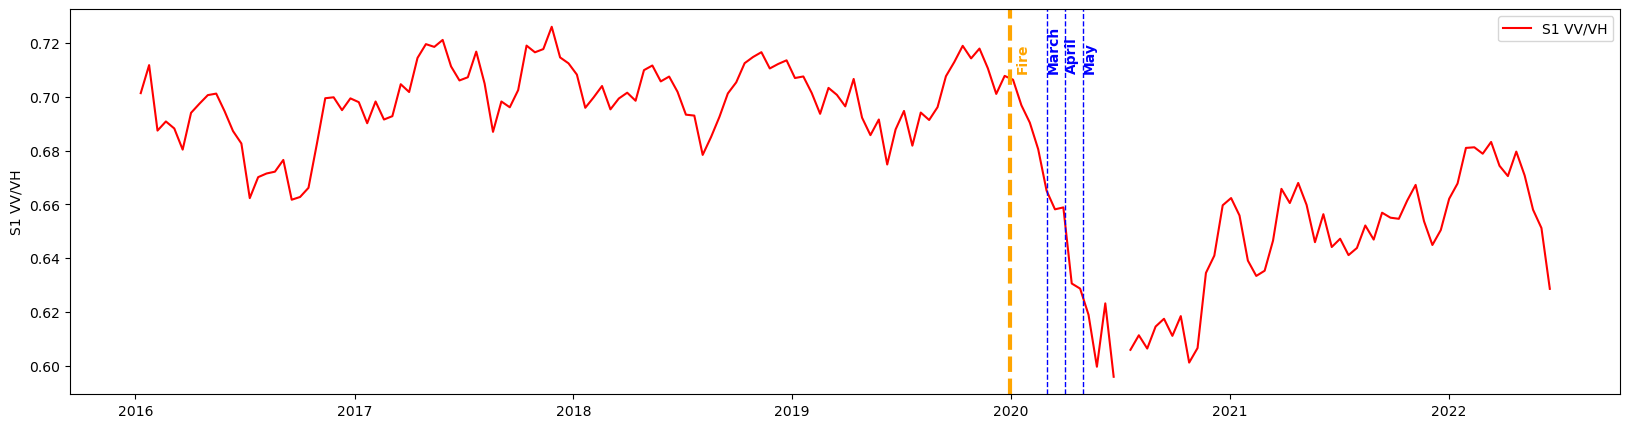

In [35]:
xarr = VV_VH_df.to_xarray()
xarr = xarr.set_index(index = 'time')
selection = xarr
selection_df = selection.to_dataframe()


x2 = selection_df.index
y2 = selection_df.VV_VH

fig, ax = plt.subplots(figsize=(20, 5))
p1, = ax.plot(x2,y2,'r-', label='S1 VV/VH')

ax.set_ylabel("S1 VV/VH")

plt.axvline(pd.datetime(2019,12,31),lw=3,c='orange',ls='--')
plt.axvline(np.datetime64('2020-03-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-04-01'),lw=1,c='blue',ls='--')
plt.axvline(np.datetime64('2020-05-01'),lw=1,c='blue',ls='--')
#Annotation V lines
x_text_annotation = dt.datetime(2020,1,10)
plt.text(x=x_text_annotation, y=0.71, s='Fire', alpha=1, color='orange', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,3,1)
plt.text(x=x_text_annotation6, y=0.71, s='March', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,4,1)
plt.text(x=x_text_annotation6, y=0.71, s='April', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
x_text_annotation6 = dt.datetime(2020,5,1)
plt.text(x=x_text_annotation6, y=0.71, s='May', alpha=1, color='blue', fontweight = 'bold', rotation = 'vertical')
ax.legend(handles=[p1])

plt.savefig(fname='S1_VV_VH_FULL_Smoothed.jpg', dpi=400, facecolor='w', edgecolor='w',
    transparent=False, bbox_inches='tight', pad_inches=0.1,
    frameon=None, metadata=None)

